<a href="https://colab.research.google.com/github/rokugatsu/HomeCreditDefaultRisk/blob/main/My_competition2_v132.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

Omni: 0.75602

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [1]:
#pip install sweetviz

In [2]:
#import sweetviz as sv

In [3]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

必要なデータの読み込みを行います。GCIの教材フォルダの構成を想定して、読み込んでいます。

In [4]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
#%cd "/content/drive/MyDrive"
%cd "/content/drive/MyDrive/data/competition2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data/competition2


In [5]:
#Switch Kaggle or Omini
key_kaggle = False

In [6]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./input/"

if key_kaggle == True:
  #For kaggle
  train = pd.read_csv(INPUT_DIR + "application_train.csv")
  test  = pd.read_csv(INPUT_DIR + "application_test.csv")
  sample_sub = pd.read_csv(INPUT_DIR + "sample_submission_kaggle.csv")
else:
  #For Omni
  train = pd.read_csv(INPUT_DIR + "train.csv")
  test = pd.read_csv(INPUT_DIR + "test.csv")
  sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

#sample_sub

## 1. データの可視化と分析

### 1.1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

In [7]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)
#train.head(10)

train shape: (171202, 51)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


In [8]:
# testデータの確認
print(f"test shape: {test.shape}")
train.head(3)
#test.head(10)

test shape: (61500, 50)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


特徴量が50種類もあることが分かります。このnotebookでは、50種類全ての特徴量について分析することはせず、5種類の特徴量に絞って分析を行います。今回のように特徴量が多い場合は、初めから全ての特徴量に対して、分析や前処理を行うのは大変だと思います。なので、初めは少ない特徴量で予測結果を出すことを目標に取り組んでみて、それから扱う特徴量を増やしてみると取り組みやすいです。残りの45種類の特徴量については、今までの教材やこのnotebook等を参考にして、自分の力で分析を行ってみてください。


使用する5種類の特徴量については、様々な処理の説明を行えるように選択しています。

In [9]:
test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIA

sweetviz

In [10]:
#report = sv.analyze(train, target_feat="TARGET")

In [11]:
#report.show_notebook()

In [12]:
#report.show_html("eda.html")

In [13]:
# 5種類の特徴量に絞る
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "EXT_SOURCE_2", "OWN_CAR_AGE", "ORGANIZATION_TYPE"]
#target = train["TARGET"].values
#train = train[use_features]
#train["TARGET"] = target
#test = test[use_features]

In [14]:
# 5種類の特徴量に絞る
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_HOUSING_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_INCOME_TYPE","OCCUPATION_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE","NAME_INCOME_TYPE","AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","OCCUPATION_TYPE","REGION_RATING_CLIENT","REGION_RATING_CLIENT_W_CITY"]
#use_features = ["NAME_CONTRACT_TYPE","NAME_INCOME_TYPE","AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","OCCUPATION_TYPE"]

#target = train["TARGET"].values
#train_ft = train[use_features]
#train_ft["TARGET"] = target
#test_ft = test[use_features]

再度、データの確認を行います。

In [15]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 51)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


In [16]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 50)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,171202,Cash loans,F,N,N,1,144000.0,961146.0,28233.0,688500.0,...,NaN,2.0,0.0,2.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,171203,Cash loans,F,N,N,0,103500.0,296280.0,16069.5,225000.0,...,NaN,5.0,0.0,5.0,0.0,-212.0,NaN,NaN,NaN,NaN
2,171204,Cash loans,F,N,Y,1,180000.0,183694.5,11236.5,139500.0,...,0.389339,7.0,0.0,7.0,0.0,-428.0,0.0,1.0,1.0,1.0


### 1.2 データの可視化・分析(EDA)
データを可視化して分析を行います。この作業では、特徴量の値の分布, 欠損値, 外れ値, 相関関係などの確認を行うことでデータへの理解を深めます。この段階で得られる分析結果を元に、前処理、特徴量の作成、機械学習モデルの選択などを行うので、最終的な予測に大きく影響する重要な作業となります。Kaggle上でも様々な方がEDAを行ったコードが公開されているので、参考にしてみると良いです。

#### 1.2.1 欠損値の確認
ここでは、欠損値の確認を行います。
ほとんどの機械学習モデルでは、欠損値があるデータで学習を行うことができません。そのため、何かしらの値で欠損値を埋める必要があるので、欠損値の確認を必ず行います。

#Examine Missing Values

Next we can look at the number and percentage of missing values in each column.


In [17]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [18]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 51 columns.
There are 20 columns that have missing values.


,Missing Values,% of Total Values
EXT_SOURCE_1,118928,69.5
OWN_CAR_AGE,112992,66.0
EXT_SOURCE_3,54586,31.9
OCCUPATION_TYPE,53745,31.4
FLAG_OWN_REALTY,34241,20.0
FLAG_OWN_CAR,34241,20.0
AMT_REQ_CREDIT_BUREAU_HOUR,23116,13.5
AMT_REQ_CREDIT_BUREAU_MON,23116,13.5
AMT_REQ_CREDIT_BUREAU_QRT,23116,13.5
AMT_REQ_CREDIT_BUREAU_YEAR,23116,13.5


In [19]:
train.dtypes.value_counts()

int64      20
float64    20
object     11
Name: count, dtype: int64

In [20]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE      2
CODE_GENDER             3
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
NAME_TYPE_SUITE         7
NAME_INCOME_TYPE        8
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      6
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        18
ORGANIZATION_TYPE      58
dtype: int64

In [21]:
# trainの欠損値を確認
train.isnull().sum()

SK_ID_CURR                          0
TARGET                              0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                    34241
FLAG_OWN_REALTY                 34241
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                         6
AMT_GOODS_PRICE                   163
NAME_TYPE_SUITE                   747
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                    112992
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE  

In [22]:
# testの欠損値を確認
test.isnull().sum()

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                   12334
FLAG_OWN_REALTY                12334
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        3
AMT_GOODS_PRICE                   53
NAME_TYPE_SUITE                  248
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                    40909
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

In [23]:
#train['DEF_OBS'].fillna(train['DEF_OBS'].mean(), inplace=True)
train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].mean(),inplace=True)
test['AMT_ANNUITY'].fillna(test['AMT_ANNUITY'].mean(),inplace=True)

train['AMT_CREDIT'].fillna(train['AMT_CREDIT'].mean(),inplace=True)
test['AMT_CREDIT'].fillna(test['AMT_CREDIT'].mean(),inplace=True)

train['AMT_INCOME_TOTAL'].fillna(train['AMT_INCOME_TOTAL'].mean(),inplace=True)
test['AMT_INCOME_TOTAL'].fillna(test['AMT_INCOME_TOTAL'].mean(),inplace=True)

train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].mean(),inplace=True)
test['AMT_GOODS_PRICE'].fillna(test['AMT_GOODS_PRICE'].mean(),inplace=True)

train['CNT_FAM_MEMBERS'].fillna(train['CNT_FAM_MEMBERS'].mean(),inplace=True)
test['CNT_FAM_MEMBERS'].fillna(test['CNT_FAM_MEMBERS'].mean(),inplace=True)

あるユーザがお金を借りた額を，同じ職業のユーザがお金を借りた額の平均値と比較する


In [24]:
#for i in range(len(train)):
#    print(i, train.loc[i,'OCCUPATION_TYPE'])
train['OCCUPATION_TYPE'].fillna('Unsettled',inplace = True)
test['OCCUPATION_TYPE'].fillna('Unsettled',inplace = True)

In [25]:
print(train['OCCUPATION_TYPE'].unique())
df_train_credit=train.groupby('OCCUPATION_TYPE')['AMT_CREDIT'].mean()
df_train_credit

['Core staff' 'Unsettled' 'Drivers' 'Cleaning staff' 'Cooking staff'
 'Managers' 'Sales staff' 'Laborers' 'Low-skill Laborers' 'Accountants'
 'Private service staff' 'Medicine staff' 'High skill tech staff'
 'Security staff' 'IT staff' 'Waiters/barmen staff' 'Realty agents'
 'Secretaries' 'HR staff']


OCCUPATION_TYPE
Accountants              704147.296041
Cleaning staff           516764.589209
Cooking staff            539109.664330
Core staff               623677.113385
Drivers                  612407.340626
HR staff                 680553.014563
High skill tech staff    640417.302662
IT staff                 649182.573529
Laborers                 571488.104726
Low-skill Laborers       456407.079016
Managers                 777204.778912
Medicine staff           601762.445932
Private service staff    644582.995882
Realty agents            651892.867788
Sales staff              561697.068538
Secretaries              611663.125984
Security staff           548594.000933
Unsettled                575771.834636
Waiters/barmen staff     494963.626506
Name: AMT_CREDIT, dtype: float64

In [26]:
print(test['OCCUPATION_TYPE'].unique())
df_test_credit=test.groupby('OCCUPATION_TYPE')['AMT_CREDIT'].mean()
df_test_credit

['Medicine staff' 'Cleaning staff' 'Unsettled' 'Managers' 'Drivers'
 'Sales staff' 'Private service staff' 'Laborers' 'High skill tech staff'
 'Realty agents' 'Waiters/barmen staff' 'Accountants' 'Core staff'
 'Cooking staff' 'HR staff' 'Secretaries' 'Security staff'
 'Low-skill Laborers' 'IT staff']


OCCUPATION_TYPE
Accountants              721857.713337
Cleaning staff           491683.140379
Cooking staff            525002.568893
Core staff               625856.965790
Drivers                  601235.977758
HR staff                 737253.000000
High skill tech staff    647978.242226
IT staff                 625157.663551
Laborers                 568069.038251
Low-skill Laborers       445015.240385
Managers                 770492.813428
Medicine staff           617430.048561
Private service staff    629531.103321
Realty agents            664333.193878
Sales staff              558973.021426
Secretaries              598855.125000
Security staff           571948.827649
Unsettled                569570.558824
Waiters/barmen staff     486533.822300
Name: AMT_CREDIT, dtype: float64

In [27]:
for i in df_train_credit.index:
  #print(i,df[i])
  for j in range(len(train)):
    if train.loc[j,'OCCUPATION_TYPE'] == i:
      #print(i,test.loc[j,'OCCUPATION_TYPE'])
      train.loc[j,'AMT_CREDIT_RATE'] =  train.loc[j,'AMT_CREDIT']/df_train_credit[i]

In [28]:
#train['AMT_CREDIT_RATE']

In [29]:
for i in df_test_credit.index:
  #print(i,df[i])
  for j in range(len(test)):
    if test.loc[j,'OCCUPATION_TYPE'] == i:
      #print(i,test.loc[j,'OCCUPATION_TYPE'])
      test.loc[j,'AMT_CREDIT_RATE'] =  test.loc[j,'AMT_CREDIT']/df_test_credit[i]

In [30]:
#test['AMT_CREDIT_RATE']

あるユーザの年金額を，同じ職業のユーザの年金額の平均値と比較する

In [31]:
df_train_annuity=train.groupby('OCCUPATION_TYPE')['AMT_ANNUITY'].mean() #NAME_EDUCATION_TYPE
#df_train_annuity=train.groupby('NAME_EDUCATION_TYPE')['AMT_ANNUITY'].mean() #NAME_EDUCATION_TYPE
df_train_annuity

OCCUPATION_TYPE
Accountants              30794.838721
Cleaning staff           23104.831905
Cooking staff            25046.811214
Core staff               27629.426560
Drivers                  29041.851637
HR staff                 30004.747573
High skill tech staff    28587.700313
IT staff                 28664.867647
Laborers                 26491.842349
Low-skill Laborers       23211.516839
Managers                 34886.476170
Medicine staff           25722.537837
Private service staff    29729.300961
Realty agents            29923.344952
Sales staff              26156.602765
Secretaries              27194.338583
Security staff           24719.121669
Unsettled                25657.173793
Waiters/barmen staff     24475.783133
Name: AMT_ANNUITY, dtype: float64

In [32]:
df_test_annuity=test.groupby('OCCUPATION_TYPE')['AMT_ANNUITY'].mean()
#df_test_annuity=test.groupby('NAME_EDUCATION_TYPE')['AMT_ANNUITY'].mean()
df_test_annuity

OCCUPATION_TYPE
Accountants              31514.069075
Cleaning staff           22262.020505
Cooking staff            24598.814455
Core staff               27462.976090
Drivers                  29025.618251
HR staff                 30007.186364
High skill tech staff    28877.842497
IT staff                 28952.116822
Laborers                 26460.821279
Low-skill Laborers       23117.336538
Managers                 34576.607067
Medicine staff           26073.048895
Private service staff    28318.441882
Realty agents            30179.908163
Sales staff              26037.511735
Secretaries              27353.671846
Security staff           25740.555152
Unsettled                25442.590691
Waiters/barmen staff     24289.024390
Name: AMT_ANNUITY, dtype: float64

In [33]:
for i in df_train_annuity.index:
  #print(i,df[i])
  for j in range(len(train)):
    if train.loc[j,'OCCUPATION_TYPE'] == i:
    #if train.loc[j,'NAME_EDUCATION_TYPE'] == i:
      #print(i,test.loc[j,'OCCUPATION_TYPE'])
      train.loc[j,'AMT_ANNUITY_RATE'] =  train.loc[j,'AMT_ANNUITY']/df_train_annuity[i]

In [34]:
#train['AMT_ANNUITY_RATE']

In [35]:
for i in df_test_annuity.index:
  #print(i,df[i])
  for j in range(len(test)):
    if test.loc[j,'OCCUPATION_TYPE'] == i:
    #if test.loc[j,'NAME_EDUCATION_TYPE'] == i:
      #print(i,test.loc[j,'OCCUPATION_TYPE'])
      test.loc[j,'AMT_ANNUITY_RATE'] =  test.loc[j,'AMT_ANNUITY']/df_test_annuity[i]

In [36]:
#test['AMT_ANNUITY_RATE']

In [37]:
train[['OCCUPATION_TYPE','AMT_CREDIT','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]

,OCCUPATION_TYPE,AMT_CREDIT,AMT_CREDIT_RATE,AMT_ANNUITY_RATE
0,Core staff,755190.0,1.210867,1.314848
1,Unsettled,585000.0,1.016027,0.658412
2,Core staff,334152.0,0.535777,0.660763
3,Unsettled,152820.0,0.265418,0.346921
4,Drivers,271066.5,0.442625,0.741895
...,...,...,...,...
171197,Laborers,404325.0,0.707495,0.784090
171198,Cooking staff,601470.0,1.115673,1.160447
171199,Core staff,1237684.5,1.984496,1.781307
171200,Sales staff,239850.0,0.427010,0.962912


In [38]:
test[['OCCUPATION_TYPE','AMT_CREDIT','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]

,OCCUPATION_TYPE,AMT_CREDIT,AMT_CREDIT_RATE,AMT_ANNUITY_RATE
0,Medicine staff,961146.0,1.556688,1.082842
1,Cleaning staff,296280.0,0.602583,0.721835
2,Unsettled,183694.5,0.322514,0.441641
3,Unsettled,450000.0,0.790069,0.884344
4,Unsettled,545040.0,0.956931,1.047063
...,...,...,...,...
61495,Managers,1288350.0,1.672112,1.093225
61496,Sales staff,273636.0,0.489533,0.591762
61497,Accountants,291384.0,0.403658,0.848050
61498,Unsettled,746280.0,1.310250,2.322641


In [39]:
train[['SK_ID_CURR','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']].to_csv('m_train_amt_credit.csv', index = False)
test[['SK_ID_CURR','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']].to_csv('m_test_amt_credit.csv', index = False)

#Encoding Categorical Variables¶

Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

*   Label encoding
*   One-hot encoding


# Label Encoding and One-Hot Encoding¶

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.


In [40]:
#train['NAME_EDUCATION_TYPE']

In [41]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

1 columns were label encoded.


In [42]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (171202, 159)
Testing Features shape:  (61500, 156)


In [43]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (171202, 157)
Testing Features shape:  (61500, 156)


#### 1.2.2 各特徴量の可視化・分析
ここでは、各特徴量について可視化を行い、どのような特徴があるのか分析します。

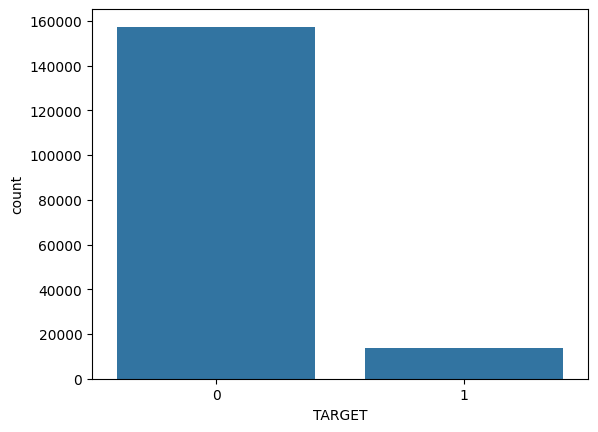

In [44]:
# 目的変数（債務不履行かどうか）の分布
sns.countplot(data=train, x="TARGET")
plt.show()

目的変数の分布が大きく偏っていることが分かります。このように目的変数の分布が大きく偏っているデータのことを不均衡データと呼びます。


不均衡データを扱う際は、特に評価指標の選び方に注意する必要があります。例えば、今回の評価指標として正解率（Accuracy）を選択すると、全て0と予測するだけで高正解率となることがわかると思います。このような適切でない評価指標を選択すると機械学習モデルがうまく学習できない原因となります。

また、不均衡データへの対処として、目的変数の分布を均衡にしようとするアプローチもあります。多い方の目的変数のデータを減らす手法をアンダーサンプリング、少ない方の目的変数のデータを増やす方法をオーバーサンプリングと呼びます。

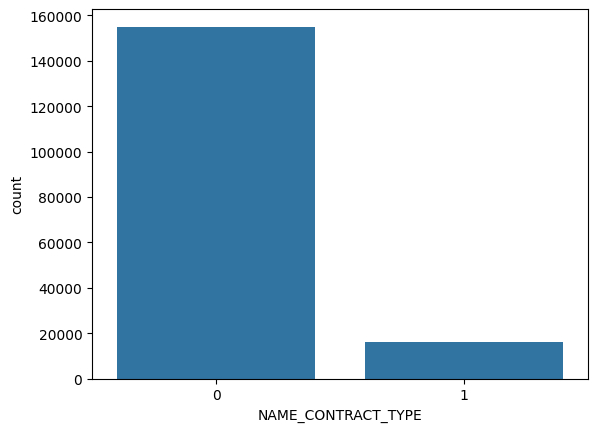

In [45]:
# NAME_CONTRACT_TYPE
sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
plt.show()

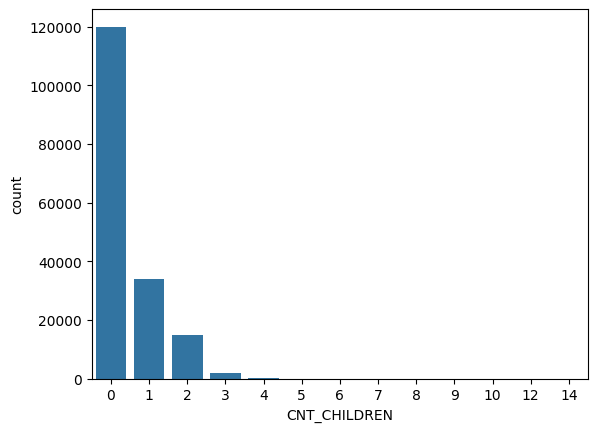

In [46]:
# CNT_CHILDREN
#sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
sns.countplot(data=train, x="CNT_CHILDREN")
plt.show()

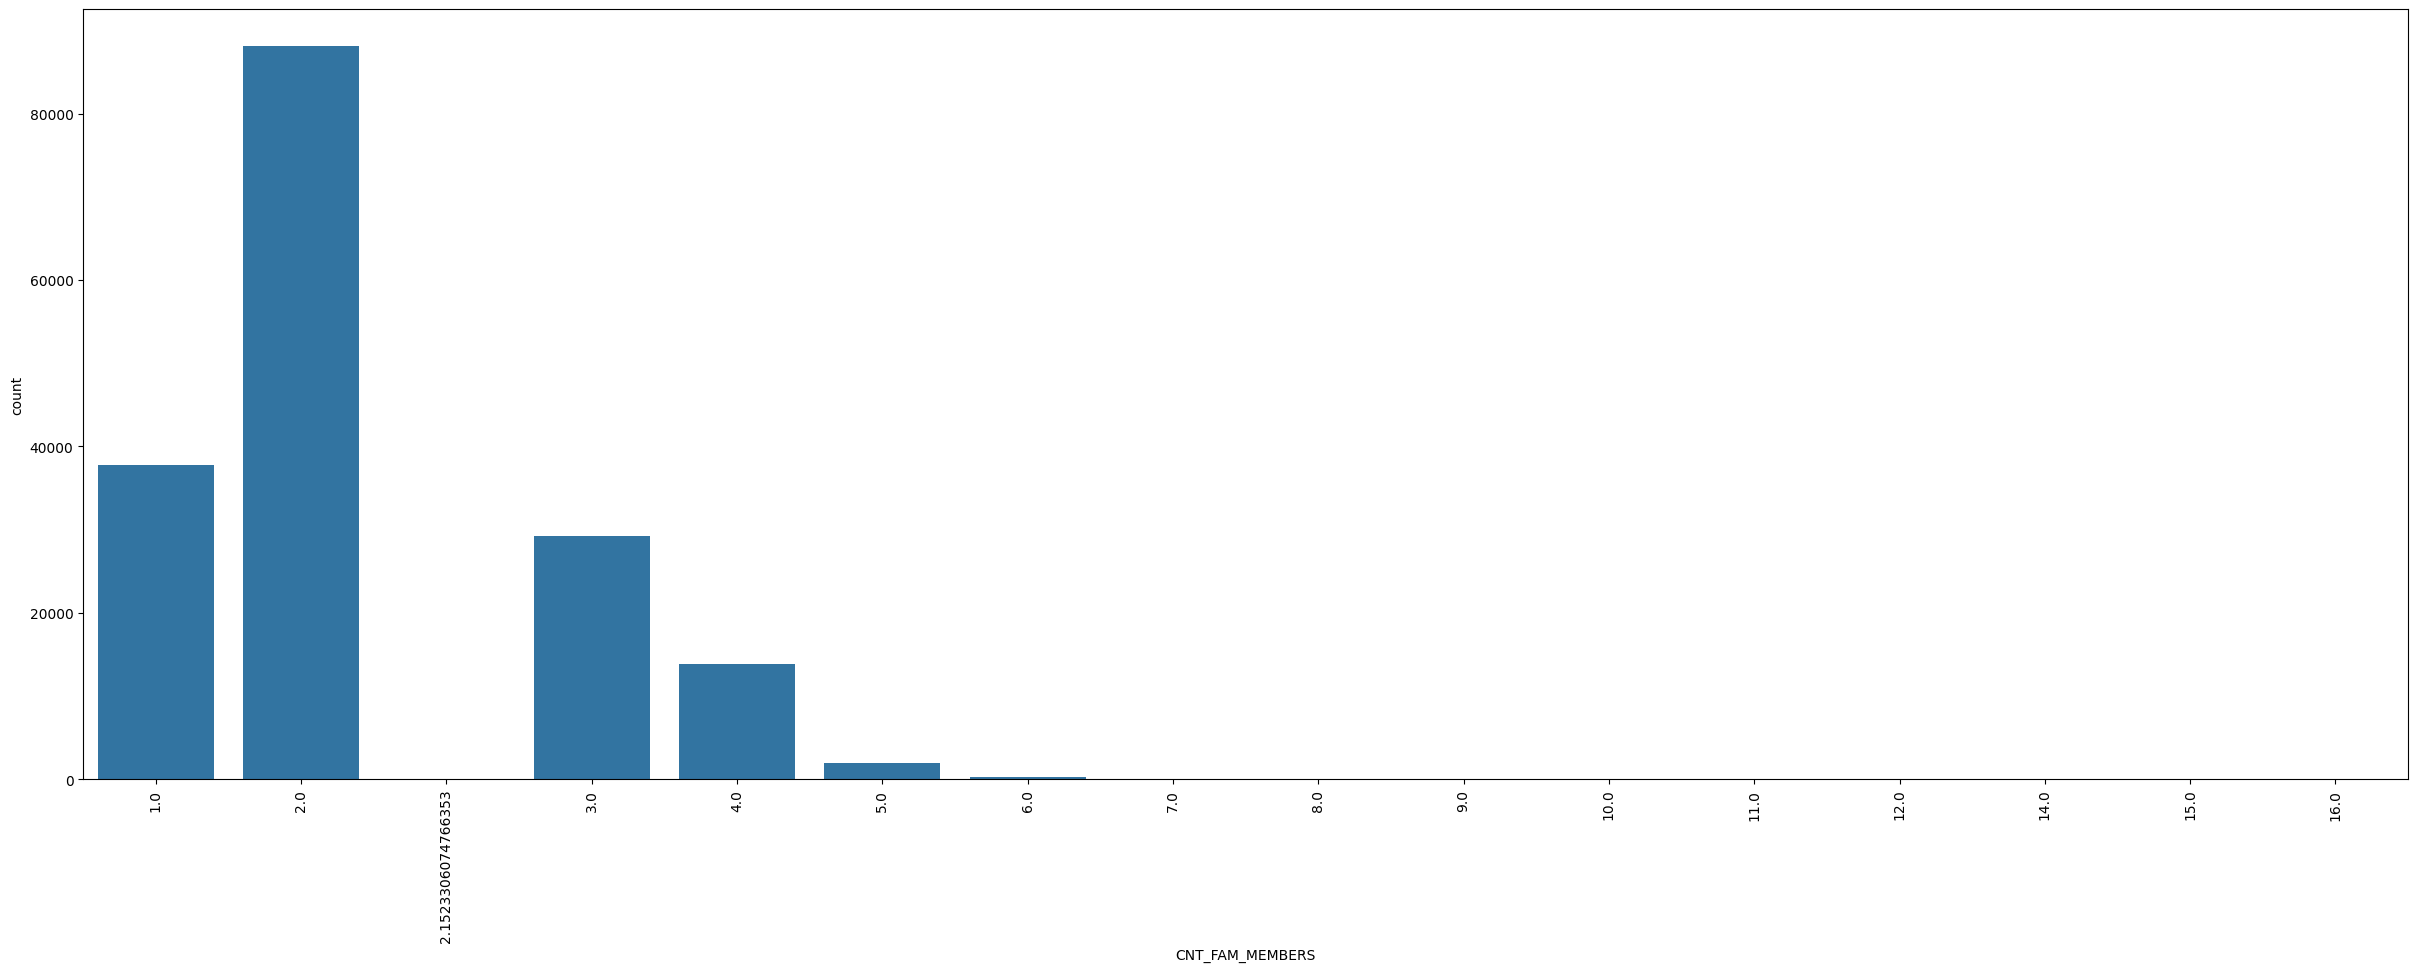

In [47]:
# CNT_FAM_MEMBERS
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="CNT_FAM_MEMBERS")
plt.tick_params(axis="x", rotation=90)
plt.show()

In [48]:
# DAYS_BIRTHの分布
#print((train['DAYS_BIRTH'] / -365).describe())
#train['DAYS_BIRTH'] = (train['DAYS_BIRTH'] / -365)
#sns.displot(data=train, x="DAYS_BIRTH")
#plt.show()

In [49]:
print(train['DAYS_EMPLOYED'].describe())

count    171202.000000
mean      63960.411969
std      141401.513149
min      -17912.000000
25%       -2772.000000
50%       -1215.000000
75%        -288.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


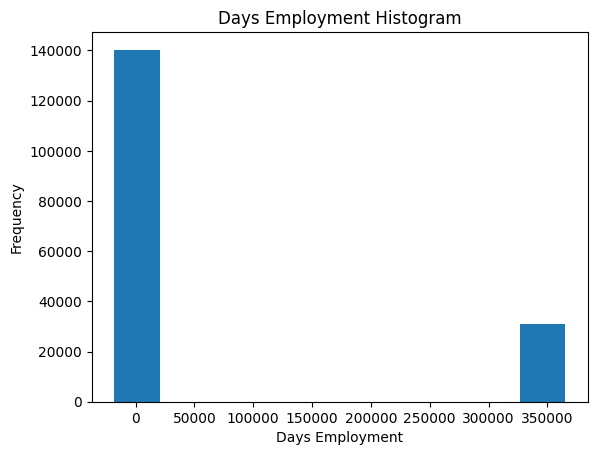

In [50]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [51]:
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.42% of loans
There are 30898 anomalous days of employment


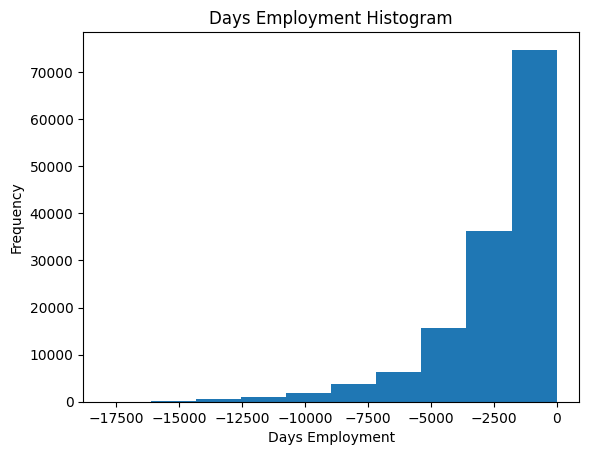

In [52]:
# Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['AMT_INCOME_TOTAL'].fillna(train['AMT_INCOME_TOTAL'].mean(),inplace=True)

train['DAYS_EMPLOYED_FIL'] = train['DAYS_EMPLOYED'].fillna(train['DAYS_EMPLOYED'].mean())

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [53]:
# ヒストグラムの描写
# x軸のラベルを指定
#plt.xlabel('DAYS_EMPLOYED', fontsize=15)
#plt.xlabel('hist', fontsize=15)
#plt.hist(x=train['DAYS_EMPLOYED'], bins=10, range=(-20000, 0))

In [54]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

test["DAYS_EMPLOYED_FIL"] = test["DAYS_EMPLOYED"].fillna(test["DAYS_EMPLOYED"].mean())

print('There are %d anomalies in the test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

There are 10565 anomalies in the test data out of 61500 entries


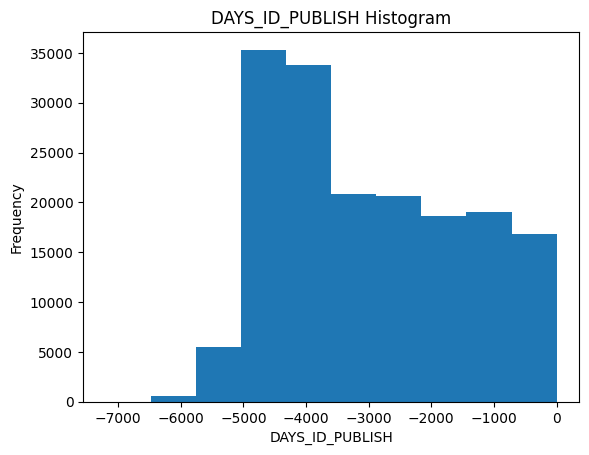

In [55]:
train['DAYS_ID_PUBLISH'].plot.hist(title = 'DAYS_ID_PUBLISH Histogram');
plt.xlabel('DAYS_ID_PUBLISH');

In [56]:
train['DAYS_LAST_PHONE_CHANGE'].fillna(train['DAYS_LAST_PHONE_CHANGE'].mean(),inplace=True)
test['DAYS_LAST_PHONE_CHANGE'].fillna(test['DAYS_LAST_PHONE_CHANGE'].mean(),inplace=True)

# Correlations¶

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

    .00-.19 “very weak”
    .20-.39 “weak”
    .40-.59 “moderate”
    .60-.79 “strong”
    .80-1.0 “very strong”



In [57]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041669
REG_CITY_NOT_LIVE_CITY                               0.043829
FLAG_EMP_PHONE                                       0.045646
NAME_EDUCATION_TYPE_Secondary / secondary special    0.048799
REG_CITY_NOT_WORK_CITY                               0.049438
DAYS_ID_PUBLISH                                      0.052567
CODE_GENDER_M                                        0.054457
DAYS_LAST_PHONE_CHANGE                               0.055195
NAME_INCOME_TYPE_Working                             0.055869
REGION_RATING_CLIENT                                 0.058984
REGION_RATING_CLIENT_W_CITY                          0.061132
DAYS_EMPLOYED_FIL                                    0.068781
DAYS_EMPLOYED                                        0.073608
DAYS_BIRTH                                           0.079541
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [58]:
#train['AMT_CREDIT_RATE']

In [59]:
(train['AMT_CREDIT_RATE']).corr(train['TARGET'])

-0.026872943064500936

In [60]:
(train['AMT_CREDIT']).corr(train['TARGET'])

-0.03272742635034188

In [61]:
(train['AMT_ANNUITY_RATE']).corr(train['TARGET'])

-0.01049204491570986

In [62]:
train['NAME_EDUCATION_TYPE_Higher education'].corr(train['TARGET'])

-0.0562699976405556

In [63]:
# Find the correlation of the positive days since birth and target
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = abs(test['DAYS_BIRTH'])

train['DAYS_BIRTH'].corr(train['TARGET'])
#test['DAYS_BIRTH']

-0.07954132269839942

In [64]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])
train['DAYS_EMPLOYED'].corr(train['TARGET'])

-0.07360761123097671

In [65]:
train['DAYS_ID_PUBLISH'] = abs(train['DAYS_ID_PUBLISH'])
test['DAYS_ID_PUBLISH'] = abs(test['DAYS_ID_PUBLISH'])
train['DAYS_ID_PUBLISH'].corr(train['TARGET'])

-0.05256731275680315

In [66]:
train['DAYS_REGISTRATION'] = abs(train['DAYS_REGISTRATION'])
test['DAYS_REGISTRATION'] = abs(test['DAYS_REGISTRATION'])
train['DAYS_REGISTRATION'].corr(train['TARGET'])

-0.041669249843892475

In [67]:
train['DAYS_EMPLOYED_FIL'] = abs(train['DAYS_EMPLOYED_FIL'])
test['DAYS_EMPLOYED_FIL'] = abs(test['DAYS_EMPLOYED_FIL'])
(train['DAYS_EMPLOYED_FIL']*train['EXT_SOURCE_2']).corr(train['TARGET'])

-0.10237811336640366

Preparation

In [68]:
train['EXT_SOURCE_1'].fillna(train.EXT_SOURCE_1.mean(),inplace=True)
train['EXT_SOURCE_2'].fillna(train.EXT_SOURCE_2.mean(),inplace=True)
train['EXT_SOURCE_3'].fillna(train.EXT_SOURCE_3.mean(),inplace=True)

test['EXT_SOURCE_1'].fillna(test.EXT_SOURCE_1.mean(),inplace=True)
test['EXT_SOURCE_2'].fillna(test.EXT_SOURCE_2.mean(),inplace=True)
test['EXT_SOURCE_3'].fillna(test.EXT_SOURCE_3.mean(),inplace=True)

#X_pf_item_train = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT']]
#X_pf_item_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT']]

DAYSの交差項

In [69]:
#X_pf_item_train = train[['DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DAYS_EMPLOYED_FIL','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]
X_pf_item_train = train[['DAYS_ID_PUBLISH','DAYS_REGISTRATION','DAYS_EMPLOYED_FIL','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]

X_pf_item_train.isnull().sum()

#X_pf_item_test = test[['DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DAYS_EMPLOYED_FIL','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]
X_pf_item_test = test[['DAYS_ID_PUBLISH','DAYS_REGISTRATION','DAYS_EMPLOYED_FIL','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]

X_pf_item_test.isnull().sum()

DAYS_ID_PUBLISH      0
DAYS_REGISTRATION    0
DAYS_EMPLOYED_FIL    0
AMT_CREDIT_RATE      0
AMT_ANNUITY_RATE     0
dtype: int64

In [70]:
from sklearn.preprocessing import PolynomialFeatures

num_cross = 3

# 交差項作成器の作成
pf = PolynomialFeatures(degree=num_cross, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_train = pf.fit_transform(X_pf_item_train)

# 変数の数の確認
interaction_feature_count = X_pf_train.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_train = pd.DataFrame(X_pf_train, columns=pf.get_feature_names_out(input_features=X_pf_item_train.columns))
X_pf_df_train.head()

## test
pf_test = PolynomialFeatures(degree=num_cross, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_test = pf.fit_transform(X_pf_item_test)

# 変数の数の確認
interaction_feature_count = X_pf_test.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_test= pd.DataFrame(X_pf_test, columns=pf.get_feature_names_out(input_features=X_pf_item_test.columns))
X_pf_df_test.head()

交差項を含む変数の数: 25
交差項を含む変数の数: 25


,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED_FIL,AMT_CREDIT_RATE,AMT_ANNUITY_RATE,DAYS_ID_PUBLISH DAYS_REGISTRATION,DAYS_ID_PUBLISH DAYS_EMPLOYED_FIL,DAYS_ID_PUBLISH AMT_CREDIT_RATE,DAYS_ID_PUBLISH AMT_ANNUITY_RATE,DAYS_REGISTRATION DAYS_EMPLOYED_FIL,...,DAYS_ID_PUBLISH DAYS_REGISTRATION DAYS_EMPLOYED_FIL,DAYS_ID_PUBLISH DAYS_REGISTRATION AMT_CREDIT_RATE,DAYS_ID_PUBLISH DAYS_REGISTRATION AMT_ANNUITY_RATE,DAYS_ID_PUBLISH DAYS_EMPLOYED_FIL AMT_CREDIT_RATE,DAYS_ID_PUBLISH DAYS_EMPLOYED_FIL AMT_ANNUITY_RATE,DAYS_ID_PUBLISH AMT_CREDIT_RATE AMT_ANNUITY_RATE,DAYS_REGISTRATION DAYS_EMPLOYED_FIL AMT_CREDIT_RATE,DAYS_REGISTRATION DAYS_EMPLOYED_FIL AMT_ANNUITY_RATE,DAYS_REGISTRATION AMT_CREDIT_RATE AMT_ANNUITY_RATE,DAYS_EMPLOYED_FIL AMT_CREDIT_RATE AMT_ANNUITY_RATE
0,3022.0,2446.0,2372.0,1.556688,1.082842,7391812.0,7168184.0,4704.311393,3272.349404,5801912.0,...,1.753338e+10,1.150675e+07,8.004167e+06,1.115863e+07,7.762013e+06,5094.027327,9.031767e+06,6.282556e+06,4123.094256,3998.356327
1,253.0,10450.0,1712.0,0.602583,0.721835,2643850.0,433136.0,152.453550,182.624192,17890400.0,...,4.526271e+09,1.593140e+06,1.908423e+06,2.610005e+05,3.126526e+05,110.046270,1.078045e+07,1.291391e+07,4545.389404,744.660924
2,4495.0,1056.0,553.0,0.322514,0.441641,4746720.0,2485735.0,1449.700594,1985.177851,583968.0,...,2.624936e+09,1.530884e+06,2.096348e+06,8.016844e+05,1.097803e+06,640.247722,1.883379e+05,2.579044e+05,150.411923,78.766850
3,1189.0,6096.0,1438.0,0.790069,0.884344,7248144.0,1709782.0,939.391954,1051.484903,8766048.0,...,1.042283e+10,5.726533e+06,6.409852e+06,1.350846e+06,1.512035e+06,830.745548,6.925782e+06,7.752201e+06,4259.230331,1004.720016
4,1728.0,3257.0,2362.0,0.956931,1.047063,5628096.0,4081536.0,1653.577604,1809.325181,7693034.0,...,1.329356e+10,5.385702e+06,5.892972e+06,3.905750e+06,4.273626e+06,1731.400230,7.361706e+06,8.055093e+06,3263.408882,2366.647768


In [71]:
# Merge polynomial features into training dataframe
X_pf_df_train['SK_ID_CURR'] = train['SK_ID_CURR']
train.drop(['DAYS_ID_PUBLISH','DAYS_REGISTRATION','DAYS_EMPLOYED_FIL','AMT_CREDIT_RATE','AMT_ANNUITY_RATE'], axis=1,inplace=True)
train= train.merge(X_pf_df_train, on ='SK_ID_CURR', how = 'left')
#train

In [72]:
X_pf_df_test['SK_ID_CURR'] = test['SK_ID_CURR']
test.drop(['DAYS_ID_PUBLISH','DAYS_REGISTRATION','DAYS_EMPLOYED_FIL','AMT_CREDIT_RATE','AMT_ANNUITY_RATE'], axis=1,inplace=True)
test= test.merge(X_pf_df_test, on ='SK_ID_CURR', how = 'left')
#test

In [73]:
#train['DAYS_BIRTH']

AMT

In [74]:
#train['DEF_OBS'].fillna(train['DEF_OBS'].mean(), inplace=True)
#train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].mean(),inplace=True)
#test['AMT_ANNUITY'].fillna(test['AMT_ANNUITY'].mean(),inplace=True)

#train['AMT_CREDIT'].fillna(train['AMT_CREDIT'].mean(),inplace=True)
#test['AMT_CREDIT'].fillna(test['AMT_CREDIT'].mean(),inplace=True)

#train['AMT_INCOME_TOTAL'].fillna(train['AMT_INCOME_TOTAL'].mean(),inplace=True)
#test['AMT_INCOME_TOTAL'].fillna(test['AMT_INCOME_TOTAL'].mean(),inplace=True)

#train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].mean(),inplace=True)
#test['AMT_GOODS_PRICE'].fillna(test['AMT_GOODS_PRICE'].mean(),inplace=True)

#train['CNT_FAM_MEMBERS'].fillna(train['CNT_FAM_MEMBERS'].mean(),inplace=True)
#test['CNT_FAM_MEMBERS'].fillna(test['CNT_FAM_MEMBERS'].mean(),inplace=True)

In [75]:
X_pf_item_train = train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',]]
X_pf_item_train.isnull().sum()

X_pf_item_test = test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT']]
X_pf_item_test.isnull().sum()

AMT_INCOME_TOTAL        0
AMT_CREDIT              0
AMT_ANNUITY             0
AMT_GOODS_PRICE         0
CNT_FAM_MEMBERS         0
REGION_RATING_CLIENT    0
dtype: int64

In [76]:
from sklearn.preprocessing import PolynomialFeatures

num_cross = 3

# 交差項作成器の作成
pf = PolynomialFeatures(degree=num_cross , include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_train = pf.fit_transform(X_pf_item_train)

# 変数の数の確認
interaction_feature_count = X_pf_train.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_train = pd.DataFrame(X_pf_train, columns=pf.get_feature_names_out(input_features=X_pf_item_train.columns))
X_pf_df_train.head()

## test
pf_test = PolynomialFeatures(degree=num_cross , include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_test = pf.fit_transform(X_pf_item_test)

# 変数の数の確認
interaction_feature_count = X_pf_test.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_test= pd.DataFrame(X_pf_test, columns=pf.get_feature_names_out(input_features=X_pf_item_test.columns))
X_pf_df_test.head()

交差項を含む変数の数: 41
交差項を含む変数の数: 41


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,AMT_INCOME_TOTAL AMT_CREDIT,AMT_INCOME_TOTAL AMT_ANNUITY,AMT_INCOME_TOTAL AMT_GOODS_PRICE,AMT_INCOME_TOTAL CNT_FAM_MEMBERS,...,AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE,AMT_CREDIT AMT_ANNUITY CNT_FAM_MEMBERS,AMT_CREDIT AMT_ANNUITY REGION_RATING_CLIENT,AMT_CREDIT AMT_GOODS_PRICE CNT_FAM_MEMBERS,AMT_CREDIT AMT_GOODS_PRICE REGION_RATING_CLIENT,AMT_CREDIT CNT_FAM_MEMBERS REGION_RATING_CLIENT,AMT_ANNUITY AMT_GOODS_PRICE CNT_FAM_MEMBERS,AMT_ANNUITY AMT_GOODS_PRICE REGION_RATING_CLIENT,AMT_ANNUITY CNT_FAM_MEMBERS REGION_RATING_CLIENT,AMT_GOODS_PRICE CNT_FAM_MEMBERS REGION_RATING_CLIENT
0,144000.0,961146.0,28233.0,688500.0,3.0,2.0,1.384050e+11,4.065552e+09,9.914400e+10,432000.0,...,1.868316e+16,8.140811e+10,5.427207e+10,1.985247e+12,1.323498e+12,5766876.0,5.831526e+10,3.887684e+10,169398.0,4131000.0
1,103500.0,296280.0,16069.5,225000.0,2.0,2.0,3.066498e+10,1.663193e+09,2.328750e+10,207000.0,...,1.071241e+15,9.522143e+09,9.522143e+09,1.333260e+11,1.333260e+11,1185120.0,7.231275e+09,7.231275e+09,64278.0,900000.0
2,180000.0,183694.5,11236.5,139500.0,2.0,3.0,3.306501e+10,2.022570e+09,2.511000e+10,360000.0,...,2.879396e+14,4.128166e+09,6.192250e+09,5.125077e+10,7.687615e+10,1102167.0,3.134984e+09,4.702475e+09,67419.0,837000.0
3,225000.0,450000.0,22500.0,450000.0,4.0,2.0,1.012500e+11,5.062500e+09,1.012500e+11,900000.0,...,4.556250e+15,4.050000e+10,2.025000e+10,8.100000e+11,4.050000e+11,3600000.0,4.050000e+10,2.025000e+10,180000.0,3600000.0
4,144000.0,545040.0,26640.0,450000.0,4.0,3.0,7.848576e+10,3.836160e+09,6.480000e+10,576000.0,...,6.533940e+15,5.807946e+10,4.355960e+10,9.810720e+11,7.358040e+11,6540480.0,4.795200e+10,3.596400e+10,319680.0,5400000.0


In [77]:
# Merge polynomial features into training dataframe
X_pf_df_train['SK_ID_CURR'] = train['SK_ID_CURR']
train.drop(['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT'], axis=1,inplace=True)
train= train.merge(X_pf_df_train, on ='SK_ID_CURR', how = 'left')
#train

In [78]:
X_pf_df_test['SK_ID_CURR'] = test['SK_ID_CURR']
test.drop(['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT'], axis=1,inplace=True)
test= test.merge(X_pf_df_test, on ='SK_ID_CURR', how = 'left')
#test

FLAG交差項

In [79]:
X_pf_item_train = train[['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']]
X_pf_item_train.isnull().sum()

X_pf_item_test = test[['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']]
X_pf_item_test.isnull().sum()

#X_pf_item_train = train[['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']]
#X_pf_item_train.isnull().sum()

#X_pf_item_test = test[['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE']]
#X_pf_item_test.isnull().sum()

FLAG_EMP_PHONE     0
FLAG_WORK_PHONE    0
FLAG_PHONE         0
dtype: int64

In [80]:
from sklearn.preprocessing import PolynomialFeatures

num_cross = 3

# 交差項作成器の作成
pf = PolynomialFeatures(degree=num_cross, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_train = pf.fit_transform(X_pf_item_train)

# 変数の数の確認
interaction_feature_count = X_pf_train.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_train = pd.DataFrame(X_pf_train, columns=pf.get_feature_names_out(input_features=X_pf_item_train.columns))
X_pf_df_train.head()

## test
pf_test = PolynomialFeatures(degree=num_cross, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_test = pf.fit_transform(X_pf_item_test)

# 変数の数の確認
interaction_feature_count = X_pf_test.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_test= pd.DataFrame(X_pf_test, columns=pf.get_feature_names_out(input_features=X_pf_item_test.columns))
X_pf_df_test.head()

交差項を含む変数の数: 7
交差項を含む変数の数: 7


,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMP_PHONE FLAG_WORK_PHONE,FLAG_EMP_PHONE FLAG_PHONE,FLAG_WORK_PHONE FLAG_PHONE,FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_PHONE
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Merge polynomial features into training dataframe
X_pf_df_train['SK_ID_CURR'] = train['SK_ID_CURR']
#train.drop(['FLAG_EMP_PHONE','FLAG_WORK_PHONE'], axis=1,inplace=True)
train.drop(['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE'], axis=1,inplace=True)

train= train.merge(X_pf_df_train, on ='SK_ID_CURR', how = 'left')
#train

In [82]:
X_pf_df_test['SK_ID_CURR'] = test['SK_ID_CURR']
#test.drop(['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE'], axis=1,inplace=True)
test.drop(['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE'], axis=1,inplace=True)
test= test.merge(X_pf_df_test, on ='SK_ID_CURR', how = 'left')
#test

REGION_POPULATION_RELATIVE, DEF_60_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE

In [83]:
train['REGION_POPULATION_RELATIVE'].fillna(train['REGION_POPULATION_RELATIVE'].mean(),inplace=True)
test['REGION_POPULATION_RELATIVE'].fillna(test['REGION_POPULATION_RELATIVE'].mean(),inplace=True)

train['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(train['DEF_30_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)
test['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(test['DEF_30_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)

train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(train['DEF_60_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)
test['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(test['DEF_60_CNT_SOCIAL_CIRCLE'].mean(),inplace=True)

In [84]:
X_pf_item_train = train[['REGION_POPULATION_RELATIVE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']]
X_pf_item_train.isnull().sum()

X_pf_item_test = test[['REGION_POPULATION_RELATIVE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']]
X_pf_item_test.isnull().sum()

REGION_POPULATION_RELATIVE    0
DEF_30_CNT_SOCIAL_CIRCLE      0
DEF_60_CNT_SOCIAL_CIRCLE      0
dtype: int64

In [85]:
from sklearn.preprocessing import PolynomialFeatures

# 交差項作成器の作成
pf = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_train = pf.fit_transform(X_pf_item_train)

# 変数の数の確認
interaction_feature_count = X_pf_train.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_train = pd.DataFrame(X_pf_train, columns=pf.get_feature_names_out(input_features=X_pf_item_train.columns))
X_pf_df_train.head()

## test
pf_test = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_test = pf.fit_transform(X_pf_item_test)

# 変数の数の確認
interaction_feature_count = X_pf_test.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_test= pd.DataFrame(X_pf_test, columns=pf.get_feature_names_out(input_features=X_pf_item_test.columns))
X_pf_df_test.head()

交差項を含む変数の数: 7
交差項を含む変数の数: 7


,REGION_POPULATION_RELATIVE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_30_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE
0,0.025164,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007020,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006852,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035792,0.0,0.0,0.0,0.0,0.0,0.0
4,0.020713,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Merge polynomial features into training dataframe
X_pf_df_train['SK_ID_CURR'] = train['SK_ID_CURR']
train.drop(['REGION_POPULATION_RELATIVE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'], axis=1,inplace=True)
train= train.merge(X_pf_df_train, on ='SK_ID_CURR', how = 'left')
#train

In [87]:
X_pf_df_test['SK_ID_CURR'] = test['SK_ID_CURR']
test.drop(['REGION_POPULATION_RELATIVE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'], axis=1,inplace=True)
test= test.merge(X_pf_df_test, on ='SK_ID_CURR', how = 'left')
#test

In [88]:
# Set the style of plots
#plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
#plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
#plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [89]:
#plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
#sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = "target == 0")

# KDE plot of loans which were not repaid on time
#sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
#plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [90]:
#plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
#sns.kdeplot(train.loc[train['TARGET'] == 0, 'OBS_60_CNT_SOCIAL_CIRCLE'], label = "target == 0")

# KDE plot of loans which were not repaid on time
#sns.kdeplot(train.loc[train['TARGET'] == 1, 'OBS_60_CNT_SOCIAL_CIRCLE'], label = 'target == 1')

# Labeling of plot
#plt.xlabel('years'); plt.ylabel('Density'); plt.title('Distribution of AMT_REQ_CREDIT_BUREAU_YEAR');

In [91]:
#plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
#sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_ID_PUBLISH'] / 365, label = "target == 0")

# KDE plot of loans which were not repaid on time
#sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_ID_PUBLISH'] / 365, label = 'target == 1')

# Labeling of plot
#plt.xlabel('years'); plt.ylabel('Density'); plt.title('Distribution of DAYS_ID_PUBLISH');

In [92]:
# Age information into a separate dataframe
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,0,9233,25.295890,"(25.0, 30.0]"
1,0,20148,55.200000,"(55.0, 60.0]"
2,0,18496,50.673973,"(50.0, 55.0]"
3,0,24177,66.238356,"(65.0, 70.0]"
4,1,10685,29.273973,"(25.0, 30.0]"
5,1,16795,46.013699,"(45.0, 50.0]"
6,0,14519,39.778082,"(35.0, 40.0]"
7,1,8624,23.627397,"(20.0, 25.0]"
8,0,14614,40.038356,"(40.0, 45.0]"
9,1,17604,48.230137,"(45.0, 50.0]"


In [93]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.121158,8529.472370,23.368417
"(25.0, 30.0]",0.113253,10154.840252,27.821480
"(30.0, 35.0]",0.104347,11853.590292,32.475590
"(35.0, 40.0]",0.087437,13707.096396,37.553689
"(40.0, 45.0]",0.079911,15498.153588,42.460695
"(45.0, 50.0]",0.074576,17323.833949,47.462559
"(50.0, 55.0]",0.065109,19195.188720,52.589558
"(55.0, 60.0]",0.055200,20980.426906,57.480622
"(60.0, 65.0]",0.053512,22777.943940,62.405326


In [94]:
#plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
#plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
#plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
#plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.


#Exterior Sources¶

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.


In [95]:
#train['OBS_DEF_60'] = train['DEF_60_CNT_SOCIAL_CIRCLE'] /train['OBS_60_CNT_SOCIAL_CIRCLE']
#test['OBS_DEF_60'] = test['DEF_60_CNT_SOCIAL_CIRCLE'] /test['OBS_60_CNT_SOCIAL_CIRCLE']

train['DEF_OBS'] = (train['DEF_30_CNT_SOCIAL_CIRCLE'] + train['DEF_60_CNT_SOCIAL_CIRCLE']) / (train['OBS_30_CNT_SOCIAL_CIRCLE'] + train['OBS_60_CNT_SOCIAL_CIRCLE'])
test['DEF_OBS'] = (test['DEF_30_CNT_SOCIAL_CIRCLE'] + test['DEF_60_CNT_SOCIAL_CIRCLE']) / (test['OBS_30_CNT_SOCIAL_CIRCLE'] + test['OBS_60_CNT_SOCIAL_CIRCLE'])

train['DEF_OBS'].fillna(train['DEF_OBS'].mean(), inplace=True)
test['DEF_OBS'].fillna(test['DEF_OBS'].mean(), inplace=True)
train['DEF_OBS'].isnull().sum()

0

In [96]:
# Extract the EXT_SOURCE variables and show correlations
#ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
#ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','DAYS_EMPLOYED']]
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DEF_OBS','NAME_EDUCATION_TYPE_Higher education']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DEF_OBS,NAME_EDUCATION_TYPE_Higher education
TARGET,1.000000,-0.082239,-0.162391,-0.144070,-0.079541,-0.073608,-0.052567,0.008036,0.011507,0.033038,0.029236,-0.056270
EXT_SOURCE_1,-0.082239,1.000000,0.113611,0.085116,0.298287,0.133413,0.071733,-0.056425,-0.016241,-0.017253,-0.010507,0.078316
EXT_SOURCE_2,-0.162391,0.113611,1.000000,0.089500,0.089355,0.094088,0.051504,0.000790,-0.020153,-0.033893,-0.028437,0.126543
EXT_SOURCE_3,-0.144070,0.085116,0.089500,1.000000,0.168942,0.108307,0.107194,-0.021798,-0.001234,-0.028204,-0.027269,-0.021461
DAYS_BIRTH,-0.079541,0.298287,0.089355,0.168942,1.000000,0.352797,0.273862,-0.279112,-0.007877,-0.001094,0.003458,-0.117386
DAYS_EMPLOYED,-0.073608,0.133413,0.094088,0.108307,0.352797,1.000000,0.089489,-0.026410,0.001133,-0.013068,-0.014993,-0.003477
DAYS_ID_PUBLISH,-0.052567,0.071733,0.051504,0.107194,0.273862,0.089489,1.000000,0.021983,0.011709,-0.004597,-0.007357,-0.026008
CNT_FAM_MEMBERS,0.008036,-0.056425,0.000790,-0.021798,-0.279112,-0.026410,0.021983,1.000000,0.024830,-0.009257,-0.017538,0.025695
OBS_60_CNT_SOCIAL_CIRCLE,0.011507,-0.016241,-0.020153,-0.001234,-0.007877,0.001133,0.011709,0.024830,1.000000,0.230731,-0.131349,-0.048323
DEF_60_CNT_SOCIAL_CIRCLE,0.033038,-0.017253,-0.033893,-0.028204,-0.001094,-0.013068,-0.004597,-0.009257,0.230731,1.000000,0.716669,-0.031022


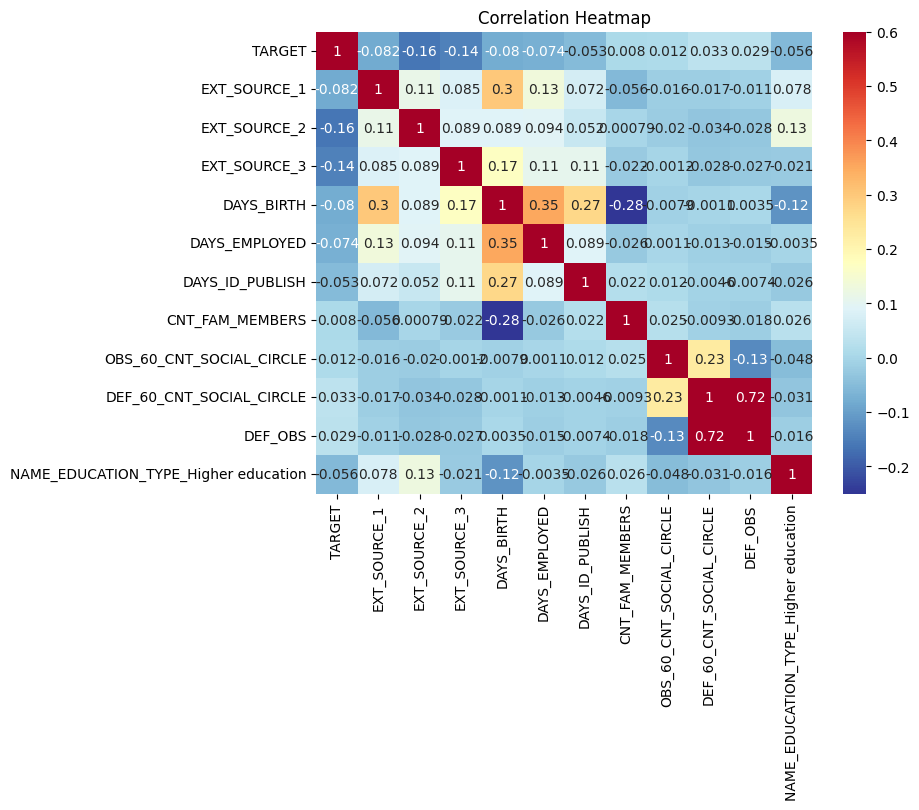

In [97]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [98]:
#plt.figure(figsize = (10, 12))

# iterate through the sources
#for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NAME_EDUCATION_TYPE_Higher education','DEF_OBS']):

    # create a new subplot for each source
#    plt.subplot(5, 1, i + 1)
    # plot repaid loans
#    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
#    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
#    plt.title('Distribution of %s by Target Value' % source)
#    plt.xlabel('%s' % source); plt.ylabel('Density');

#plt.tight_layout(h_pad = 2.5)

In [99]:
# Copy the data for plotting
#plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
#plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
#plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
#def corr_func(x, y, **kwargs):
#    r = np.corrcoef(x, y)[0][1]
#    ax = plt.gca()
#    ax.annotate("r = {:.2f}".format(r),
#                xy=(.2, .8), xycoords=ax.transAxes,
#                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
#                    hue = 'TARGET',
#                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

#grid = sns.PairGrid(data = plot_data, diag_sharey=False,
#                    hue = 'TARGET',
#                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])


# Upper is a scatter plot
#grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)

# Bottom is density plot
#grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

#plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

AMT_INCOME_TOTALは、通常通り可視化してもうまくグラフが表示されていません。このような場合には、大きな数値を取る少数の外れ値が存在することが原因であると考えられます。今回のようなデータを可視化したい場合は、対数変換を行うと上手くグラフを表示することができます。

In [100]:
# AMT_INCOME_TOTALの分布（対数変換）
#sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
#plt.show()

対数変換してグラフを描画することで、うまく表示することができました。しかし、年収というのは本来連続的な値を取るはずなのに、グラフをみると離散的な値をとっているようです。AMT_INCOME_TOTALの値の種類を確認してみましょう。

In [101]:
# AMT_INCOME_TOTALの値の種類を確認
len(train["AMT_INCOME_TOTAL"].unique())

1641

In [102]:
len(train["NAME_EDUCATION_TYPE_Higher education"].unique())

2

trainには171202個のデータが存在するのですが、AMT_INCOME_TOTALは1641種類の値のみで構成されています。具体的に上位10個の値を確認してみましょう。

In [103]:
# AMT_INCOME_TOTALの上位10個
#train["AMT_INCOME_TOTAL"].value_counts().head(10)

どうやらAMT_INCOME_TOTALは正確な年収ではなく、きりの良い数字で集計されたデータであることが分かりました。

In [104]:
# OWN_CAR_AGEの分布
#sns.displot(data=train, x="OWN_CAR_AGE")
#plt.show()

OWN_CAR_AGEは、値のスケールから年単位の値をとっていることが推測できます。また、0〜40あたりまでは自然な分布ですが、60〜70付近に不自然な分布が存在していることが分かります。車の購入年数がこのように急に値が上昇するとは、考えにくいので外れ値であると考えられます。

ここまで、各特徴量の可視化と分析を行いました。可視化をするのにも工夫が必要だったり、可視化を行うことでデータについての理解が深まることが実感できたと思います。今回扱っていない45種類の特徴量についても、今回の可視化などを参考に各自で可視化・分析を行ってみることで、必ず予測精度の向上につながると思います。

## 2. 前処理と特徴量作成
ここでは、上記の可視化と分析でわかったことを踏まえて、前処理と特徴量の作成を行います。

In [105]:
# NAME_INCOME_TYPEの数値化（Count Encoding）
#name_type_suite_ce = train["NAME_TYPE_SUITE"].value_counts()
#train["NAME_TYPE_SUITE"] = train["NAME_TYPE_SUITE"].map(name_type_suite_ce)
#test["NAME_TYPE_SUITE"] = test["NAME_TYPE_SUITE"].map(name_type_suite_ce)


In [106]:
# NAME_CONTRACT_TYPEの数値化（Label Encoding）
train["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,...,FLAG_WORK_PHONE FLAG_PHONE,FLAG_EMP_PHONE FLAG_WORK_PHONE FLAG_PHONE,REGION_POPULATION_RELATIVE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_30_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,DEF_OBS
0,0,0,0,9233,878.0,NaN,1,1,0,2,...,0.0,0.0,0.010032,0.0,0.0,0.0,0.0,0.0,0.0,0.127283
1,1,0,0,20148,NaN,NaN,1,1,0,2,...,0.0,0.0,0.008019,0.0,0.0,0.0,0.0,0.0,0.0,0.127283
2,2,0,0,18496,523.0,NaN,1,1,0,2,...,1.0,1.0,0.004960,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,0,0,24177,NaN,NaN,1,1,0,3,...,0.0,0.0,0.005002,0.0,0.0,0.0,0.0,0.0,0.0,0.127283
4,4,0,0,10685,697.0,NaN,1,1,0,3,...,0.0,0.0,0.006296,0.0,0.0,0.0,0.0,0.0,0.0,0.127283


In [107]:
# NAME_INCOME_TYPEの数値化（Count Encoding）
#name_income_type_ce = train["NAME_INCOME_TYPE"].value_counts()
#train["NAME_INCOME_TYPE"] = train["NAME_INCOME_TYPE"].map(name_income_type_ce)
#test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].map(name_income_type_ce)

#train.head(5)

In [108]:
#train['NAME_INCOME_TYPE'].corr(train['TARGET'])

In [109]:
# ORGANIZATION_TYPEの数値化（Count Encoding）
#organization_ce = train["ORGANIZATION_TYPE"].value_counts()
#train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(organization_ce)
#test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(organization_ce)
#train_ft.head(5)

In [110]:
#occupation_type_ce = train_ft["OCCUPATION_TYPE"].value_counts()
#train["OCCUPATION_TYPE"] = train["OCCUPATION_TYPE"].map(organization_ce)
#test["OCCUPATION_TYPE"] = test["OCCUPATION_TYPE"].map(organization_ce)

In [111]:
# OWN_CAR_AGEの60以上の値（外れ値）を欠損値扱いする
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

In [112]:
# OWN_CAR_AGEをグループ分け
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()

array([nan,  0.,  2.,  1.,  3.,  4.,  5.])

In [113]:
# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

train.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,...,REGION_POPULATION_RELATIVE DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,DEF_OBS,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,0,0,0,9233,878.0,1,1,0,2,0,...,0.0,0.0,0.0,0.127283,False,False,False,False,False,False
1,1,0,0,20148,NaN,1,1,0,2,0,...,0.0,0.0,0.0,0.127283,False,False,False,False,False,False
2,2,0,0,18496,523.0,1,1,0,2,0,...,0.0,0.0,0.0,0.000000,False,False,False,False,False,False
3,3,0,0,24177,NaN,1,1,0,3,0,...,0.0,0.0,0.0,0.127283,False,False,False,False,False,False
4,4,0,0,10685,697.0,1,1,0,3,0,...,0.0,0.0,0.0,0.127283,False,False,False,False,False,False


In [114]:
test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,...,REGION_POPULATION_RELATIVE DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE,DEF_OBS,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,171202,0,1,12108,2372.0,1,1,0,2,0,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
1,171203,0,0,17907,1712.0,1,1,0,2,0,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
2,171204,0,1,15221,553.0,1,1,0,3,0,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
3,171205,1,2,11217,1438.0,1,1,0,2,0,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
4,171206,0,2,11415,2362.0,1,1,0,3,0,...,0.0,0.0,0.0,0.0,False,True,False,False,False,False


Domain 特徴

In [115]:
train_domain = train.copy()
test_domain = test.copy()

train_domain['AMT_INCOME_TOTAL'].fillna(train_domain.AMT_INCOME_TOTAL.mean(),inplace=True)
train_domain['AMT_ANNUITY'].fillna(train_domain.AMT_ANNUITY.mean(),inplace=True)
train_domain['AMT_CREDIT'].fillna(train_domain.AMT_CREDIT.mean(),inplace=True)
train_domain['AMT_GOODS_PRICE'].fillna(train_domain.AMT_GOODS_PRICE.mean(),inplace=True)

train_domain['DAYS_BIRTH'].fillna(train_domain.DAYS_BIRTH.mean(),inplace=True)
train_domain['DAYS_EMPLOYED'].fillna(train_domain.DAYS_EMPLOYED.mean(),inplace=True)
train_domain['DAYS_ID_PUBLISH_PERCENT'] = train_domain['DAYS_ID_PUBLISH'] / train_domain['DAYS_BIRTH']

train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL'] #NG
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']
train_domain['AMT_GOODS_PRICE_PERCENT'] = train_domain['AMT_GOODS_PRICE'] / train_domain['AMT_INCOME_TOTAL']

train_domain['TARGET'] = train['TARGET']

train['CREDIT_TERM']=train_domain['CREDIT_TERM']
train_domain.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CNT_CHILDREN', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL',
       'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION',
       ...
       'OWN_CAR_AGE_2.0', 'OWN_CAR_AGE_3.0', 'OWN_CAR_AGE_4.0',
       'OWN_CAR_AGE_5.0', 'DAYS_ID_PUBLISH_PERCENT', 'CREDIT_INCOME_PERCENT',
       'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT',
       'AMT_GOODS_PRICE_PERCENT'],
      dtype='object', length=234)

In [116]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["CREDIT_INCOME_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["CREDIT_INCOME_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0774744827879964


False

In [117]:
#train_domain.drop(["CREDIT_INCOME_PERCENT"],axis=1,inplace=True)

In [118]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["ANNUITY_INCOME_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["ANNUITY_INCOME_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

7.497878692069872e-11


True

In [119]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["CREDIT_TERM"]
                , train_domain[train_domain["TARGET"]==0]["CREDIT_TERM"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

3.1259286872647454e-39


True

In [120]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["DAYS_EMPLOYED_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["DAYS_EMPLOYED_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

1.71324512876577e-123


True

In [121]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["AMT_GOODS_PRICE_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["AMT_GOODS_PRICE_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

1.1101180368953667e-10


True

In [122]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["DAYS_ID_PUBLISH_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["DAYS_ID_PUBLISH_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

1.6883578961653863e-06


True

In [123]:
test_domain['AMT_INCOME_TOTAL'].fillna(test_domain.AMT_INCOME_TOTAL.mean(),inplace=True)
test_domain['AMT_ANNUITY'].fillna(test_domain.AMT_ANNUITY.mean(),inplace=True)
test_domain['AMT_CREDIT'].fillna(test_domain.AMT_CREDIT.mean(),inplace=True)
test_domain['DAYS_BIRTH'].fillna(test_domain.DAYS_BIRTH.mean(),inplace=True)
test_domain['DAYS_EMPLOYED'].fillna(test_domain.DAYS_EMPLOYED.mean(),inplace=True)

test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']
test_domain['AMT_GOODS_PRICE_PERCENT'] = test_domain['AMT_GOODS_PRICE'] / test_domain['AMT_INCOME_TOTAL']


test_domain['DAYS_ID_PUBLISH_PERCENT'] = test_domain['DAYS_ID_PUBLISH'] / test_domain['DAYS_BIRTH']

test['CREDIT_TERM']=test_domain['CREDIT_TERM']

In [124]:
train_domain.isnull().sum()

SK_ID_CURR                 0
NAME_CONTRACT_TYPE         0
CNT_CHILDREN               0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
                          ..
CREDIT_INCOME_PERCENT      0
ANNUITY_INCOME_PERCENT     0
CREDIT_TERM                0
DAYS_EMPLOYED_PERCENT      0
AMT_GOODS_PRICE_PERCENT    0
Length: 234, dtype: int64

Polynomial features

Domain knowledge features

TARGET
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: EXT_SOURCE_1, dtype: object

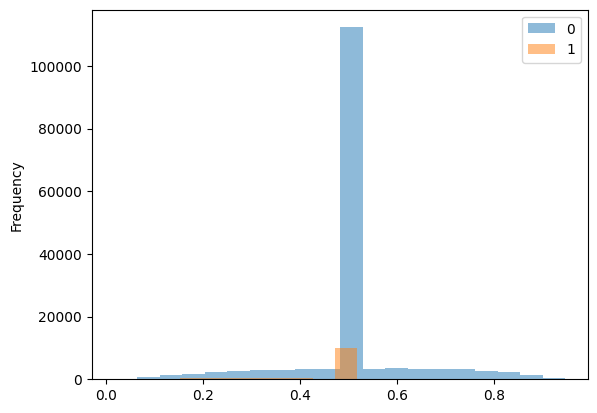

In [125]:
train.groupby('TARGET')['EXT_SOURCE_1'].plot.hist(bins=20, alpha=0.5, legend=True)

In [126]:
#train['EXT_SOURCE_1'].fillna(train.EXT_SOURCE_1.mean(),inplace=True)
#train['EXT_SOURCE_2'].fillna(train.EXT_SOURCE_2.mean(),inplace=True)
#train['EXT_SOURCE_3'].fillna(train.EXT_SOURCE_3.mean(),inplace=True)

#test['EXT_SOURCE_1'].fillna(test.EXT_SOURCE_1.mean(),inplace=True)
#test['EXT_SOURCE_2'].fillna(test.EXT_SOURCE_2.mean(),inplace=True)
#test['EXT_SOURCE_3'].fillna(test.EXT_SOURCE_3.mean(),inplace=True)

X_pf_item_train = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]
X_pf_item_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT_RATE','AMT_ANNUITY_RATE']]

In [127]:
from sklearn.preprocessing import PolynomialFeatures

num_cross = 3

# 交差項作成器の作成
#pf = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
pf = PolynomialFeatures(degree=num_cross, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_train = pf.fit_transform(X_pf_item_train)

# 変数の数の確認
interaction_feature_count = X_pf_train.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_train = pd.DataFrame(X_pf_train, columns=pf.get_feature_names_out(input_features=X_pf_item_train.columns))
X_pf_df_train.head()

## test
pf_test = PolynomialFeatures(degree=num_cross, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf_test = pf.fit_transform(X_pf_item_test)

# 変数の数の確認
interaction_feature_count = X_pf_test.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df_test= pd.DataFrame(X_pf_test, columns=pf.get_feature_names_out(input_features=X_pf_item_test.columns))
X_pf_df_test.head()

交差項を含む変数の数: 41
交差項を含む変数の数: 41


,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT_RATE,AMT_ANNUITY_RATE,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_1 AMT_CREDIT_RATE,...,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 AMT_CREDIT_RATE,EXT_SOURCE_2 EXT_SOURCE_3 AMT_ANNUITY_RATE,EXT_SOURCE_2 DAYS_BIRTH AMT_CREDIT_RATE,EXT_SOURCE_2 DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_2 AMT_CREDIT_RATE AMT_ANNUITY_RATE,EXT_SOURCE_3 DAYS_BIRTH AMT_CREDIT_RATE,EXT_SOURCE_3 DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_3 AMT_CREDIT_RATE AMT_ANNUITY_RATE,DAYS_BIRTH AMT_CREDIT_RATE AMT_ANNUITY_RATE
0,0.490984,0.720416,0.498920,12108.0,1.556688,1.082842,0.353713,0.244962,5944.837432,0.764309,...,4351.972073,0.559520,0.389205,13578.666192,9445.407946,1.214367,9403.826390,6541.362402,0.841003,20409.822262
1,0.490984,0.287306,0.498920,17907.0,0.602583,0.721835,0.141063,0.244962,8792.055161,0.295859,...,2566.838291,0.086376,0.103470,3100.165932,3713.690492,0.124968,5383.570962,6448.982646,0.217013,7788.927087
2,0.490984,0.352456,0.389339,15221.0,0.322514,0.441641,0.173050,0.191159,7473.271436,0.158349,...,2088.698329,0.044257,0.060604,1730.201416,2369.287522,0.050202,1911.258737,2617.222153,0.055456,2168.011251
3,0.490984,0.470384,0.217629,11217.0,0.790069,0.884344,0.230951,0.106852,5507.370455,0.387911,...,1148.273145,0.080879,0.090529,4168.639892,4666.062866,0.328654,1928.668158,2158.806494,0.152055,7837.235338
4,0.269931,0.373133,0.498920,11415.0,0.956931,1.047063,0.100720,0.134674,3081.261672,0.258305,...,2125.053106,0.178145,0.194925,4075.867356,4459.766160,0.373867,5449.885128,5963.200258,0.499901,11437.461588


In [128]:
# Merge polynomial features into training dataframe
X_pf_df_train['SK_ID_CURR'] = train['SK_ID_CURR']
train.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT'], axis=1,inplace=True)
train= train.merge(X_pf_df_train, on ='SK_ID_CURR', how = 'left')

In [129]:
#train

In [130]:
# Merge polynomial features into training dataframe
X_pf_df_test['SK_ID_CURR'] = test['SK_ID_CURR']
test.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT'], axis=1,inplace=True)
test = test.merge(X_pf_df_test, on ='SK_ID_CURR', how = 'left')

In [131]:
#test

In [132]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["EXT_SOURCE_1"]
                , train[train["TARGET"]==0]["EXT_SOURCE_1"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

2.0732073517913492e-182


True

In [133]:
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["EXT_SOURCE_2"]
                , train[train["TARGET"]==0]["EXT_SOURCE_2"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0


True

In [134]:
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["EXT_SOURCE_3"]
                , train[train["TARGET"]==0]["EXT_SOURCE_3"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0


True

In [135]:
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["DAYS_BIRTH"]
                , train[train["TARGET"]==0]["DAYS_BIRTH"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

4.74190439635664e-238


True

In [136]:
#plt.figure(figsize = (12, 20))
# iterate through the new features
#for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT','AMT_REQ_CREDIT_BUREAU_HOUR','DAYS_ID_PUBLISH_PERCENT']):
#for i, feature in enumerate(['ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT','AMT_REQ_CREDIT_BUREAU_HOUR','DAYS_ID_PUBLISH_PERCENT']):

    # create a new subplot for each source
#    plt.subplot(6, 1, i + 1)
    # plot repaid loans
#    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
#    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
#    plt.title('Distribution of %s by Target Value' % feature)
#    plt.xlabel('%s' % feature); plt.ylabel('Density');

#plt.tight_layout(h_pad = 2.5)

Remove Collinear Variables

In [137]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 AMT_CREDIT_RATE,EXT_SOURCE_2 EXT_SOURCE_3 AMT_ANNUITY_RATE,EXT_SOURCE_2 DAYS_BIRTH AMT_CREDIT_RATE,EXT_SOURCE_2 DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_2 AMT_CREDIT_RATE AMT_ANNUITY_RATE,EXT_SOURCE_3 DAYS_BIRTH AMT_CREDIT_RATE,EXT_SOURCE_3 DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_3 AMT_CREDIT_RATE AMT_ANNUITY_RATE,DAYS_BIRTH AMT_CREDIT_RATE AMT_ANNUITY_RATE
SK_ID_CURR,1.000000,0.000455,0.000297,0.002441,0.002207,0.000615,0.001557,0.002780,0.000800,0.003674,...,0.000685,0.003487,0.002346,0.005591,0.004026,0.005445,0.005949,0.004610,0.005866,0.007378
NAME_CONTRACT_TYPE,0.000455,1.000000,0.032189,0.037611,0.000782,0.093120,0.011657,0.023209,0.019478,0.014967,...,0.032075,0.154408,0.149747,0.170122,0.168915,0.142350,0.184101,0.187680,0.151881,0.162416
CNT_CHILDREN,0.000297,0.032189,1.000000,0.059206,0.001398,0.000467,0.024984,0.022900,0.011608,0.009863,...,0.174418,0.024353,0.017656,0.109392,0.115844,0.010286,0.121926,0.131587,0.012483,0.073746
DAYS_EMPLOYED,0.002441,0.037611,0.059206,1.000000,0.002394,0.004407,0.031290,0.010985,0.057433,0.080875,...,0.250955,0.124016,0.109938,0.178451,0.176811,0.076074,0.191300,0.190931,0.082126,0.122529
FLAG_MOBIL,0.002207,0.000782,0.001398,0.002394,1.000000,0.000099,0.000595,0.000158,0.000300,0.000558,...,0.001898,0.001377,0.000077,0.002000,0.001477,0.001125,0.002091,0.001548,0.001150,0.001535


In [138]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 AMT_CREDIT_RATE,EXT_SOURCE_2 EXT_SOURCE_3 AMT_ANNUITY_RATE,EXT_SOURCE_2 DAYS_BIRTH AMT_CREDIT_RATE,EXT_SOURCE_2 DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_2 AMT_CREDIT_RATE AMT_ANNUITY_RATE,EXT_SOURCE_3 DAYS_BIRTH AMT_CREDIT_RATE,EXT_SOURCE_3 DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_3 AMT_CREDIT_RATE AMT_ANNUITY_RATE,DAYS_BIRTH AMT_CREDIT_RATE AMT_ANNUITY_RATE
SK_ID_CURR,NaN,0.000455,0.000297,0.002441,0.002207,0.000615,0.001557,0.002780,0.000800,0.003674,...,0.000685,0.003487,0.002346,0.005591,0.004026,0.005445,0.005949,0.004610,0.005866,0.007378
NAME_CONTRACT_TYPE,NaN,NaN,0.032189,0.037611,0.000782,0.093120,0.011657,0.023209,0.019478,0.014967,...,0.032075,0.154408,0.149747,0.170122,0.168915,0.142350,0.184101,0.187680,0.151881,0.162416
CNT_CHILDREN,NaN,NaN,NaN,0.059206,0.001398,0.000467,0.024984,0.022900,0.011608,0.009863,...,0.174418,0.024353,0.017656,0.109392,0.115844,0.010286,0.121926,0.131587,0.012483,0.073746
DAYS_EMPLOYED,NaN,NaN,NaN,NaN,0.002394,0.004407,0.031290,0.010985,0.057433,0.080875,...,0.250955,0.124016,0.109938,0.178451,0.176811,0.076074,0.191300,0.190931,0.082126,0.122529
FLAG_MOBIL,NaN,NaN,NaN,NaN,NaN,0.000099,0.000595,0.000158,0.000300,0.000558,...,0.001898,0.001377,0.000077,0.002000,0.001477,0.001125,0.002091,0.001548,0.001150,0.001535


In [139]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 63 columns to remove.


In [140]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (171202, 202)
Testing shape:  (61500, 201)


In [141]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_2 AMT_CREDIT_RATE,EXT_SOURCE_2 AMT_ANNUITY_RATE,EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_3 AMT_CREDIT_RATE,EXT_SOURCE_3 AMT_ANNUITY_RATE,DAYS_BIRTH AMT_ANNUITY_RATE,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3 AMT_ANNUITY_RATE
0,0,0,0,878.0,1,1,0,2,0,1,...,0.190460,3440.129500,0.451158,0.489900,4719.698616,0.618968,0.672120,12139.992836,1758.515589,0.250426
1,1,0,0,NaN,1,1,0,2,0,0,...,0.248685,9057.874261,0.456772,0.296000,11145.162351,0.562031,0.364210,13265.691956,5010.496287,0.163737
2,2,0,0,523.0,1,1,0,2,0,0,...,0.291117,10533.533940,0.305127,0.376307,9454.732546,0.273877,0.337767,12221.470586,5384.501847,0.192359
3,3,0,0,NaN,1,1,0,3,0,0,...,0.080770,2544.256597,0.027931,0.036508,18556.406101,0.203714,0.266270,8387.497342,1952.775722,0.028021
4,4,0,0,697.0,1,1,0,3,0,0,...,0.135477,2163.602663,0.089627,0.150226,7148.870784,0.296141,0.496370,7927.146412,1447.572847,0.100510


Remove Missing Values¶

In [142]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

DAYS_EMPLOYED                 0.180477
AMT_REQ_CREDIT_BUREAU_HOUR    0.135022
AMT_REQ_CREDIT_BUREAU_YEAR    0.135022
AMT_REQ_CREDIT_BUREAU_QRT     0.135022
AMT_REQ_CREDIT_BUREAU_MON     0.135022
dtype: float64

In [143]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

DAYS_EMPLOYED                 0.171789
AMT_REQ_CREDIT_BUREAU_HOUR    0.138423
AMT_REQ_CREDIT_BUREAU_YEAR    0.138423
AMT_REQ_CREDIT_BUREAU_QRT     0.138423
AMT_REQ_CREDIT_BUREAU_MON     0.138423
dtype: float64

In [144]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 0 columns with more than 75% missing values


In [145]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (171202, 201)
Testing set full shape:  (61500, 201)


In [146]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

Feature Selection through Feature Importances

In [147]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [148]:
# LGBMClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [149]:
from sklearn.model_selection import train_test_split

# Fit the model twice to avoid overfitting
for i in range(2):

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

    # Train using early stopping
    #                callbacks=[lgb.early_stopping(stopping_rounds=10,
    #                            verbose=True), # early_stopping用コールバック関数
    #                       lgb.log_evaluation(verbose_eval)]

    model.fit(train_features, train_y,
              eval_set = [(valid_features, valid_y)],
              eval_metric = 'auc',
              callbacks=[lgb.early_stopping(stopping_rounds=100,
                        verbose=True),
                        lgb.log_evaluation(0)]
              )


    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 10388, number of negative: 118013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14090
[LightGBM] [Info] Number of data points in the train set: 128401, number of used features: 192
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=g

In [150]:
# Make sure to average feature importances!
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

#feature_importances

In [151]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 55 features with 0.0 importance


,feature,importance
112,ORGANIZATION_TYPE_Restaurant,0.0
111,ORGANIZATION_TYPE_Religion,0.0
109,ORGANIZATION_TYPE_Postal,0.0
106,ORGANIZATION_TYPE_Mobile,0.0
118,ORGANIZATION_TYPE_Telecom,0.0


In [152]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.

    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances

    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column

    """

    plt.rcParams['font.size'] = 18

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance');
    plt.title('Cumulative Feature Importance');
    plt.show();

    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    return df

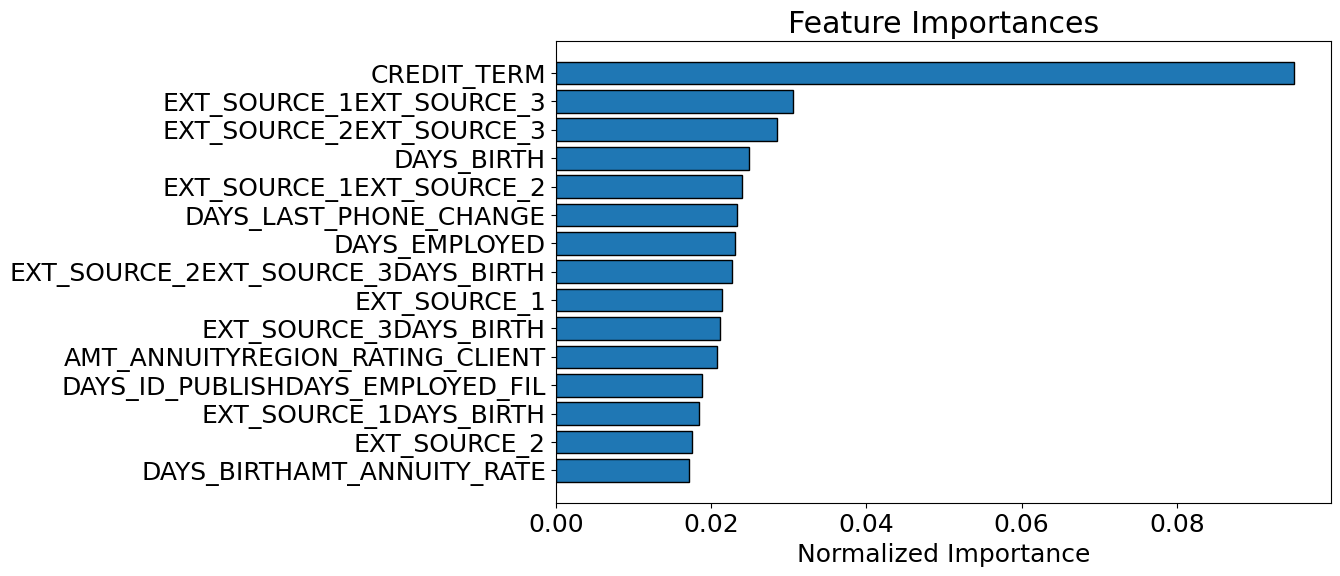

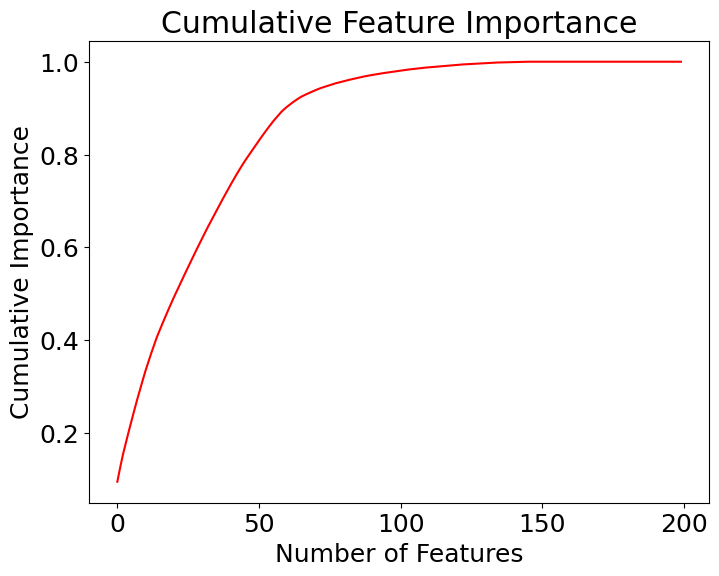

61 features required for 0.90 of cumulative importance


In [153]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [154]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (171202, 145)
Testing shape:  (61500, 145)


In [155]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the
    feature importances from a gradient boosting model.

    Parameters
    --------
    train : dataframe
        Training features

    train_labels : np.array
        Labels for training data

    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)],
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))

    return zero_features, feature_importances

In [156]:
# Threshold for cumulative importance
threshold = 0.95
#threshold = 0.9

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [157]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

In [158]:
#train_small

In [159]:
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids
#submission, feature_importances, metrics = model(train, test)

PCA¶

In [160]:
#train_fix["NAME_EDUCATION_TYPE_Higher education"]=train["NAME_EDUCATION_TYPE_Higher education"]
#test_fix["NAME_EDUCATION_TYPE_Higher education"]=test["NAME_EDUCATION_TYPE_Higher education"]

In [161]:
#train_pca = train.dropna(axis=1)

In [162]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#train_pca.isnull().sum()

In [163]:
# ライブラリの読み込み
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# データの読み込み
#cancer = load_breast_cancer()
#df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
#df['target'] = cancer.target

# 説明変数の取り出し
#X = df.iloc[:, :-1]
#X =train_pca.iloc[:, :-1]

# スケーリング
#ss = StandardScaler()
#X_std = ss.fit_transform(X)


In [164]:
#X_std

In [165]:
# PCAの適用
#pca = PCA()
#X_pca = pca.fit_transform(X_std)

# 累積寄与率の確認
#ev_ratio = pca.explained_variance_ratio_
#ev_ratio = ev_ratio.cumsum().round(3)
#ev_ratio

In [166]:
# 累積寄与率が0.8を超える主成分数を取得
#n_components = (ev_ratio < 0.8).sum() + 1
#print(f"累積寄与率が0.8を超えるために必要な主成分数: {n_components}")

# 必要な主成分数を使用してPCAを再適用
#pca = PCA(n_components=n_components)
#X_reduced = pca.fit_transform(X_std)

# 累積寄与率のプロット
#plt.figure(figsize=(8, 6))
#plt.plot(ev_ratio, marker='o', linestyle='--')
#plt.axhline(y=0.8, color='r', linestyle='-')
#plt.axvline(x=n_components-1, color='r', linestyle='-')
#plt.title('Cumulative Explained Variance by PCA Components')
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.show()

## 3. 機械学習モデルの作成
ここでは、機械学習モデルの作成を行います。

まずは、必要なライブラリを読み込みます。

- train_test_split：データを訓練用データと評価用データに分割する。
- StandardScaler：データを標準化する。
- roc_auc_score：今回の評価指標であるAUCを計算する。

In [167]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.


In [168]:
train.isnull().sum()

NAME_CONTRACT_TYPE                              0
CNT_CHILDREN                                    0
DAYS_EMPLOYED                               30898
REGION_RATING_CLIENT_W_CITY                     0
REG_REGION_NOT_LIVE_REGION                      0
                                            ...  
DAYS_BIRTHAMT_ANNUITY_RATE                      0
EXT_SOURCE_2EXT_SOURCE_3DAYS_BIRTH              0
EXT_SOURCE_2EXT_SOURCE_3AMT_ANNUITY_RATE        0
TARGET                                          0
SK_ID_CURR                                      0
Length: 147, dtype: int64

In [169]:
test.isnull().sum()

NAME_CONTRACT_TYPE                              0
CNT_CHILDREN                                    0
DAYS_EMPLOYED                               10565
REGION_RATING_CLIENT_W_CITY                     0
REG_REGION_NOT_LIVE_REGION                      0
                                            ...  
EXT_SOURCE_3AMT_ANNUITY_RATE                    0
DAYS_BIRTHAMT_ANNUITY_RATE                      0
EXT_SOURCE_2EXT_SOURCE_3DAYS_BIRTH              0
EXT_SOURCE_2EXT_SOURCE_3AMT_ANNUITY_RATE        0
SK_ID_CURR                                      0
Length: 146, dtype: int64

In [170]:
#train

In [171]:
#test

データを説明変数と目的変数に分割します。今回の目的変数は「TARGET」なので、それ以外が説明変数となります。

In [172]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [173]:
# 目的変数と説明変数に分割
X = train.drop("TARGET", axis=1)
y = train["TARGET"].values
X_test = test

データを標準化します。標準化とは、平均が0で分散が1となるように値を変換する操作です。ロジスティック回帰やニューラルネットワークなどの一部のモデルでは、このように値のスケールを揃えないと学習が上手くいきません。

学習用データのうち、7割を訓練データ、3割を評価データとして分割します。このように、学習データの一部を学習に用いずに、評価用として取っておく手法をホールドアウト法と呼びます。これにより、未知のデータに対する予測精度（汎化性能）を算出することが出来ます。

In [174]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
X.isnull().sum()

NAME_CONTRACT_TYPE                                                                0
CNT_CHILDREN                                                                      0
DAYS_EMPLOYED                                                                 30898
REGION_RATING_CLIENT_W_CITY                                                       0
REG_REGION_NOT_LIVE_REGION                                                        0
REG_REGION_NOT_WORK_REGION                                                        0
REG_CITY_NOT_LIVE_CITY                                                            0
REG_CITY_NOT_WORK_CITY                                                            0
OBS_30_CNT_SOCIAL_CIRCLE                                                        560
DAYS_LAST_PHONE_CHANGE                                                            0
AMT_REQ_CREDIT_BUREAU_MON                                                     23116
AMT_REQ_CREDIT_BUREAU_QRT                                                   

In [175]:
# 訓練データと評価データに分割
#X_train, X_valid, y_train, y_valid = train_test_split(X_std_reduced, y, test_size=0.3, stratify=y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

説明変数の絞り込み

In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# LGBMClassifier
from lightgbm import LGBMRegressor
import lightgbm as lgb

#挙動検証用　実行の確認にはこちらで問題ないです。

# 特徴選択器の作成
#rfr = RandomForestRegressor(random_state=42)

#lgb = LGBMRegressor(random_state=42)

#rfe = RFE(estimator=lgb, n_features_to_select=10)

# 交差項を含むケースで特徴選択の実行と選択された特徴量のデータフレームを作成
#rfe.fit(X_pf_df, y)# 全特徴量を使用する場合
#X_rfe = X_pf_df.loc[:, rfe.support_]

# 上は時間がかかるので元の特徴量だけで特徴選択の実行と選択された特徴量のデータフレームを作成
#rfe.fit(X, y)# 元の特徴量だけで検証する場合
#X_rfe = X.loc[:, rfe.support_]

# 選択された特徴量の数の確認
#print("選択された特徴量の数: {}".format(X_rfe.shape[1]))

# 選択された特徴量の表示
#X_rfe.head()

ロジスティック回帰と多層パーセプトロンでモデルを作成してみます。

In [177]:
#from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics

# 重回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

BaseLine_model =XGBoost

In [178]:
# LogisticRegression
#from sklearn.linear_model import LogisticRegression

#lr = LogisticRegression(random_state=0)
#lr.fit(X_train, y_train)

#lr_train_pred = lr.predict_proba(X_train)[:, 1]
#lr_valid_pred = lr.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, lr_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, lr_valid_pred)}")

In [179]:
# MLPClassifier
#from sklearn.neural_network import MLPClassifier

#mlp = MLPClassifier(random_state=0)
#mlp.fit(X_train, y_train)

#mlp_train_pred = mlp.predict_proba(X_train)[:, 1]
#mlp_valid_pred = mlp.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, mlp_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, mlp_valid_pred)}")

つぎに、勾配ブースティング木（GBDT）と呼ばれるモデルを作成してみたいと思います。GBDTは、使いやすさと精度の高さから、Kaggleなどの分析コンペでよく使用されているモデルです。GBDTの特徴として以下のような点が挙げられます。
- 欠損値のあるデータを学習できる。
- 標準化などの値のスケーリングが不要。
- 精度が高い。
- 特徴量間の相互作用が反映される。
- 特徴量が多くても精度が落ちにくく、速度が速い。

今回はGBDTの中でも代表的なxgboostとlightgbmを扱います。

In [180]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
#xgb.fit(X_train, y_train)

#xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
#xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

In [181]:
#GBM
#from sklearn.ensemble import GradientBoostingClassifier

#gb = GradientBoostingClassifier(random_state=0)
#gb.fit(X_train, y_train)

#gb_train_pred = gb.predict_proba(X_train)[:, 1]
#gb_valid_pred = gb.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, gb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, gb_valid_pred)}")

In [182]:
# LGBMClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

#lgb = LGBMClassifier(random_state=0)

#lgb.fit(X_train, y_train)
#lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
#lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

In [183]:
# 学習に使用するデータを設定
#lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# パラメータ
#params = {
#        'task': 'train',
#        'boosting_type': 'gbdt',
#        'objective': 'binary', # 目的 : 分類
#        'metric': {'auc'},
#         'num_leaves': 20,
#        'max_depth':5,
#        'min_data_in_leaf': 3,
#        'num_iteration': 100,
#        'learning_rate':0.03,
#        'num_boost_round':100,
#         'early_stopping_rounds':20,
#}

# モデルの学習
#model = lgb.train(params,
#                  train_set=lgb_train, # トレーニングデータの指定
#                  valid_sets=lgb_eval, # 検証データの指定
#                  )

# テストデータの予測
#y_pred = model.predict(X_valid)

In [184]:
#lgb.plot_importance(model, height=0.5, figsize=(30,40))

ここまでで、4つのモデルを作成しました。ここでは、アンサンブルと呼ばれる複数のモデルを組み合わせることを行います。アンサンブルには、様々な手法がありますが、今回はシンプルに4つのモデルの平均値をとることにします。

In [185]:
#train_pred = (lr_train_pred + mlp_train_pred + lgb_train_pred + xgb_train_pred)/4
#valid_pred = (lr_valid_pred + mlp_valid_pred + lgb_valid_pred + xgb_valid_pred)/4

#train_pred = (lr_train_pred + lgb_train_pred + xgb_train_pred)/3
#valid_pred = (lr_valid_pred + lgb_valid_pred + xgb_valid_pred)/3

#train_pred = (lgb_train_pred + xgb_train_pred)/2
#valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

#print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")

今回は、アンサンブルをしても精度の向上には繋がらなかったため、最終的なモデルは一番スコアの高かったxgboostを用いることにします。

やっぱり多様なModelを試してみる

In [186]:
# リッジ回帰用のクラス
# モデルの構築と評価
#linear = LinearRegression()
#ridge = Ridge(random_state=0)

#for model in [linear, ridge]:
#    model.fit(X_train, y_train)
#    print('{}(train):{:.6f}'.format(model.__class__.__name__ , model.score(X_train, y_train)))
#    print('{}(test):{:.6f}'.format(model.__class__.__name__ , model.score(X_valid, y_valid)))

In [187]:
# グリッドサーチのインポート
#from sklearn.model_selection import GridSearchCV
#
# パラメータの準備
#parameters = {
#    'max_depth': [6, 8, 10, 12, 15, 20, 30],
#    'min_data_in_leaf': [20, 25, 30, 35, 40, 45, 50, 55, 60],
#    'num_leaves': [20, 30, 40, 50, 60]
#}
#
# グリッドサーチの設定
#lgb_gcv = GridSearchCV(lgb, parameters, cv=5, scoring='roc_auc', return_train_score=True)

# グリッドサーチの実行
#lgb_gcv.fit(X_train, y_train)

LightGBM最適化

In [188]:
!pip install optuna optuna-integration

In [189]:
#import optuna
#import optuna.integration.lightgbm as lgb_tune
##LightGBM のハイパーパラメータ
#params = {
#    # 二値分類問題
#    'objective': 'binary',
#    # AUC の最大化を目指す
#    'metric': 'auc',
#    # Fatal の場合出力
#    'verbosity': -1,
#}

# データセットを生成する
#lgb_train = lgb_tune.Dataset(X_train, y_train)
#lgb_valid = lgb_tune.Dataset(X_valid, y_valid, reference=lgb_train)

#model_tune = lgb_tune.train(params, lgb_train, valid_sets=lgb_valid,
#                  num_boost_round=100,  # 最大イテレーション回数指定
#                  callbacks=[lgb_tune.early_stopping(100), lgb_tune.log_evaluation(period=100)]# ここが変わった
#                 )

In [190]:
#model_tune.params

In [191]:
#lgb=LGBMClassifier(model_tune.params)

lgb=LGBMClassifier(
    objective='binary',
    metric='auc',
    verbosity=-1,
    boosting_type = 'goss',
    n_estimators = 10000,
    class_weight = 'balanced',
    feature_pre_filter= False,
    lambda_l1=1.234755115271423e-07,
    lambda_l2=3.334611972829976e-05,
    num_leaves=31,
    feature_fraction=0.5,
    bagging_fraction=1.0,
    bagging_freq=0,
    min_child_samples=100,
    num_iterations=100)

In [192]:
models = [
    #("GBM", GradientBoostingClassifier(random_state=42)),
    #("Histogram Boosting", HistGradientBoostingClassifier(random_state=42)),
    #("SVM", SVC(probability=True, random_state=42)),
    #("XGBoost", XGBClassifier(random_state=42)),
    ("XGBoost", xgb),
    #("Catboost", CatBoostClassifier(verbose=0, random_state=42)),
    #("Regression", LogisticRegression(max_iter=600, random_state=42)),
    #("Random Forest", RandomForestClassifier(random_state=42)),
    #("K-Nearest", KNeighborsClassifier()),
    #("LGBMClassifier",LGBMClassifier(boosting_type='goss',random_state=42, verbose=-1))
    ("LGBMClassifier",lgb)
    #("MLPClassifier", MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=42))
]
#ridge = Ridge(random_state=0)
for i, (name, model) in enumerate(models, 1):
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)[:, 1]
    valid_pred = model.predict_proba(X_valid)[:, 1]
    print(f"Train Score: {roc_auc_score(y_train, train_pred)} - {name}")
    print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)} - {name}")

Train Score: 0.9195278583820021 - XGBoost
Valid Score: 0.7393480235514696 - XGBoost
Train Score: 0.823739793004881 - LGBMClassifier
Valid Score: 0.7522202961593666 - LGBMClassifier


In [193]:
#pd.set_option('display.max_columns', None)
#X_train

Croaa Validation

In [194]:
#scores[(model_name, 'cross_val_score')] = cross_val_score(model, X_train, y_train, cv=5).mean()
#roc_auc_score_cv = cross_val_score(lgb, X, y, scoring="roc_auc", cv=5).mean()
#print(f"ROC_AUC_Score Train: {roc_auc_score_cv} - cross valivation")

In [195]:
#scores = cross_val_score(lightgbm, features, target, cv=3,scoring='neg_mean_squared_error')
#roc_auc_score_train = cross_val_score(lgb, X_train, y_train, cv=5).max()
#roc_auc_score_pred = cross_val_score(lgb, X_valid, y_valid, cv=5).max()

In [196]:
#voting_clf = VotingClassifier(estimators=models, voting='soft')
#voting_clf.fit(X_train, y_train)

#roc_auc_score_train = cross_val_score(voting_clf, X_train, y_train, cv=5).max()
#roc_auc_score_pred = cross_val_score(voting_clf, X_valid, y_valid, cv=5).max()

#print(f"ROC_AUC_Score Train: {roc_auc_score_train} - Voting")
#print(f"ROC_AUC_Score Pred: {roc_auc_score_pred} - Voting")


## 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [197]:
# テストデータに対する予測値の作成
#pred = xgb.predict_proba(X_test)[:, 1]
#pred= voting_clf.predict_proba(X_test)[:, 1]
#pred= voting_clf.predict_proba(X_test_std)[:, 1]
pred = lgb.predict_proba(X_test)[:, 1]

In [198]:
#lr_pred   = lr.predict_proba(X_test)[:, 1]
#lgb_pred  = lgb.predict_proba(X_test)[:, 1]
#xgb_pred = xgb.predict_proba(X_test)[:, 1]

#pred = (lgb_pred + xgb_pred)/2.0
#pred = 0.8*lgb_pred + 0.2*xgb_pred
#pred = lgb_pred

In [199]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
#sample_sub

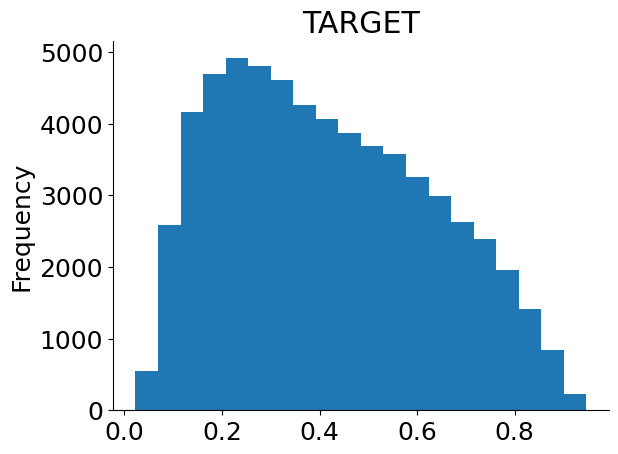

In [200]:
from matplotlib import pyplot as plt
sample_sub['TARGET'].plot(kind='hist', bins=20, title='TARGET')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [201]:
# 提出用のcsvファイルを作成
#sample_sub.to_csv('sub_competition2.csv',index=False)
if key_kaggle == True:
  sample_sub.to_csv('sub_competition2_kaggle.csv',index=False)
else:
  sample_sub.to_csv('sub_competition2.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！

In [202]:
from google.colab import files
#files.download('sub_competition2.csv')
if key_kaggle == True:
  files.download('sub_competition2_kaggle.csv')
else:
  files.download('sub_competition2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>